# Homework 2 - Unsupervised Deep Learning

In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import random 
import os 
from tqdm import tqdm 
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import itertools
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import plotly.express as px

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [ ]:
### Download the data and create dataset
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataset

In [ ]:
# define the transform to tensor
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
train_dataset.transform = data_transform
test_dataset.transform = data_transform

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)  

# Convolutional Autoencoder

## Model

In [ ]:
# define the autoencoder class
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim, activation='relu'):
        super().__init__()

        self.act = nn.ReLU()

        if activation == 'leaky':
          self.act = nn.LeakyReLU()
        elif activation == 'relu':
          self.act = nn.ReLU()
        elif activation == 'tanh':
          self.act = nn.Tanh()
        elif activation == 'elu':
          self.act = nn.ELU()

        # Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            self.act,
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            self.act,
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            self.act,
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(

            nn.Linear(3 * 3 * 64, encoded_space_dim),
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

torch.Size([256, 1, 28, 28])
torch.Size([256, 3])


In [ ]:
# define the decoder

class Decoder(nn.Module):

  def __init__(self, encoded_space_dim, activation='relu'):
    super().__init__()

    self.act = nn.ReLU()

    if activation == 'leaky':
      self.act = nn.LeakyReLU()
    elif activation == 'relu':
      self.act = nn.ReLU()
    elif activation == 'tanh':
      self.act = nn.Tanh()
    elif activation == 'elu':
      self.act = nn.ELU()

    ## linear layers
    self.decoder_lin = nn.Sequential(

        nn.Linear(encoded_space_dim, 3 * 3 * 64),
        self.act,
    )

    # unflatten
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 3, 3)) 

    # convolutional layer
    self.decoder_cnn = nn.Sequential(
        
        nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=0),
        self.act,
        nn.BatchNorm2d(32),

        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        self.act,
        nn.BatchNorm2d(16),
        
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
    )
   
  def forward(self, x):
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_cnn(x)
    x = torch.sigmoid(x)
    return x

torch.Size([256, 3])
torch.Size([256, 1, 28, 28])


In [ ]:
# Check the cuda availability
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print("The computation will be run on the device: ", device)

The computation will be run on the device:  cuda


In [ ]:
## define the training function
def train_epoch(encoder, decoder, optimizer, device, dataloader, loss_fun):

  encoder.train()
  decoder.train()

  for image, _ in train_dataloader:

    image = image.to(device)

    encoded_input = encoder(image)

    decoded_output = decoder(encoded_input)

    loss = loss_fun(decoded_output, image)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print('\t Partial loss on the batch: {}'.format(loss.data))
    return loss.data

In [ ]:
## define the test function
def test_epoch(encoder, decoder, device, dataloader, loss_fun):

    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        
        for image, _ in dataloader:

            image = image.to(device)

            encoded_input = encoder(image)

            decoded_output = decoder(encoded_input)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_output.cpu())
            conc_label.append(image.cpu())
        
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        
        # Evaluate global loss
        val_loss = loss_fun(conc_out, conc_label)
    
    return val_loss.data

In [ ]:
# define loss function and parameters to optimize
def initialize_net(parameters):

  # parameters:  batch_size, encoded_space_dim, activation, lr, weight_decay
  batch_size = parameters[0]   
  activation = parameters[2]
  lr = parameters[3]
  weight_decay = parameters[4]

  # set the seed
  torch.manual_seed(0)

  # create encoder and decoder
  encoded_space_dim = parameters[1]
  encoder = Encoder(encoded_space_dim, activation)
  decoder = Decoder(encoded_space_dim, activation)
  
  encoder.to(device)
  decoder.to(device)

  params_to_optimize = [{'params':encoder.parameters()},
                        {'params':decoder.parameters()}]

  loss_fun = nn.MSELoss()

  optimizer = optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay) 
  # optimizer = optim.SGD(params_to_optimize, lr=lr, momentum=0.9, weight_decay=weight_decay) 

  print('Network and parameters initialized')

  return encoder, decoder, loss_fun, optimizer

In [ ]:
# reset weights function
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

## Hyperparameter Optimization

In [ ]:
# define hyperparameter set
def set_hyperparameters():

  import itertools

  batch_size_set = [256]                
  enc_dim_set = [2, 4, 16]
  activation_set = ['leaky', 'relu', 'elu']
  lr_set = [3e-3] 
  weight_decay = [1e-5, 1e-6]

  param_grid = itertools.product(batch_size_set, enc_dim_set, activation_set, lr_set, weight_decay)

  n_iter = len(batch_size_set)*len(enc_dim_set)*len(activation_set)*len(lr_set)*len(weight_decay)

  return param_grid, n_iter

Network and parameters initialized
Training on hyperparameter set 1 out of 18
Training on fold: 0
EPOCH 1/500


C:\Users\david\anaconda3\envs\gputorch\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)




	 VALIDATION - EPOCH 1/500 - loss: 0.234225


EPOCH 2/500


C:\Users\david\anaconda3\envs\gputorch\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\david\anaconda3\envs\gputorch\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




	 VALIDATION - EPOCH 2/500 - loss: 0.231775


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.229174


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.226305


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.223104


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.219534


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.215617


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.211429


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.206998


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.202426


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.197710


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.192828


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.187850


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.182724


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.177577


EPOCH 16/500


	 VALIDATION - EPOCH 16/500 - loss: 0.172491


EPOCH 17/500


	 VALIDATION - EPOCH 17/500 - loss: 0.167621


EPOCH 18/500


	 VALIDATION - EPOCH 

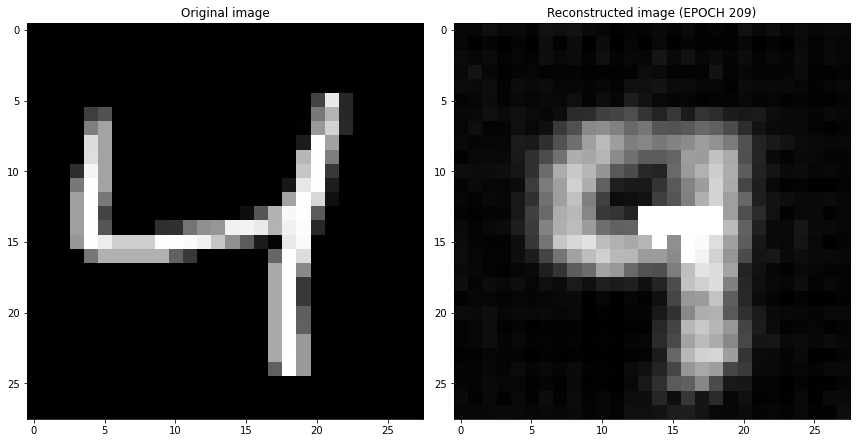

Training on hyperparameter set 1 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.092579


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.083774


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.080519


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.083318


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.087881


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.087884


EARLY STOPPING


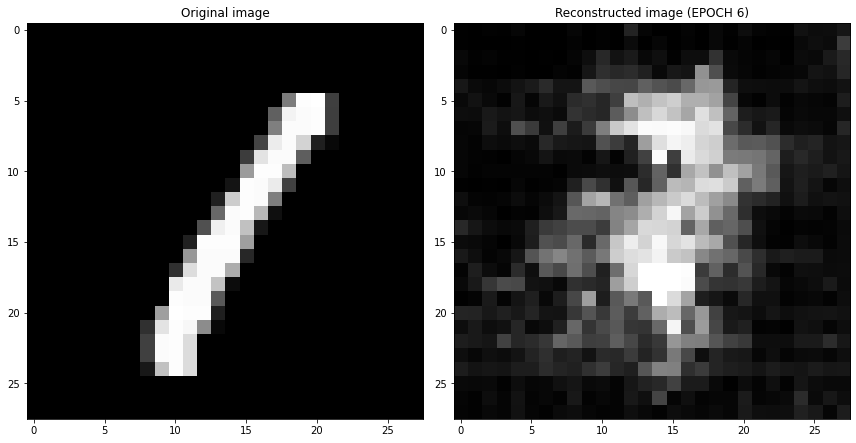

Training on hyperparameter set 1 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.090418


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.087131


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.095252


EARLY STOPPING


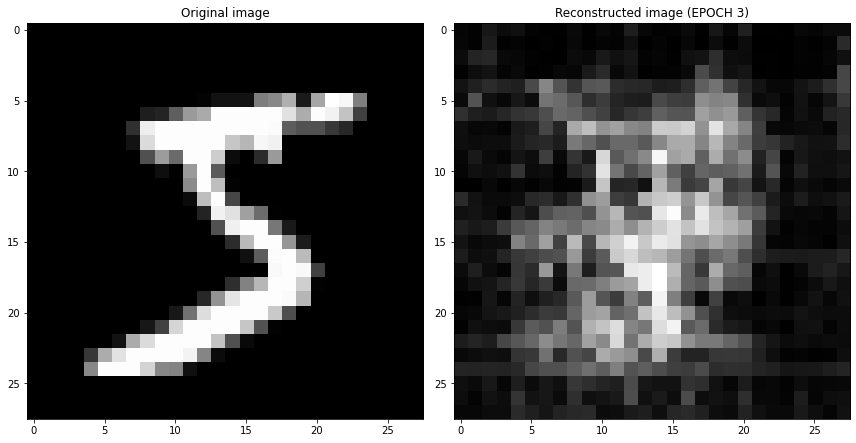

Training on hyperparameter set 1 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.087859


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.086679


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.084443


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.083682


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.084502


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.086435


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.088141


EARLY STOPPING


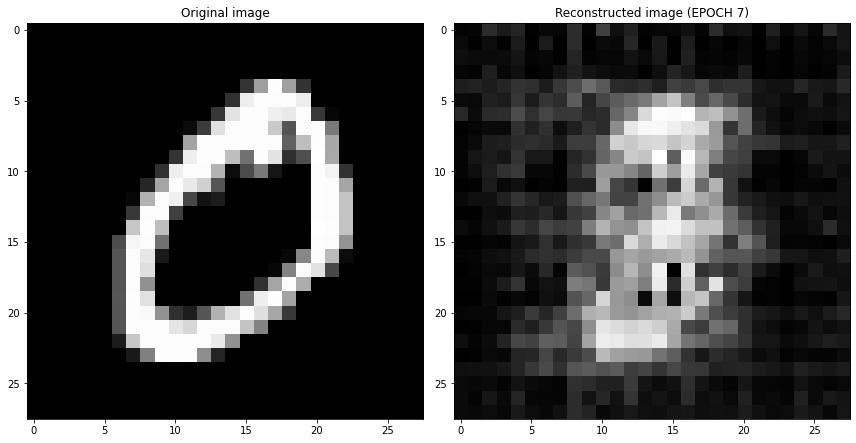

Network and parameters initialized
Training on hyperparameter set 2 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.234220


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.231771


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.229168


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.226297


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.223093


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.219519


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.215598


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.211403


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.206966


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.202397


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.197695


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.192831


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.187872


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.182755


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0

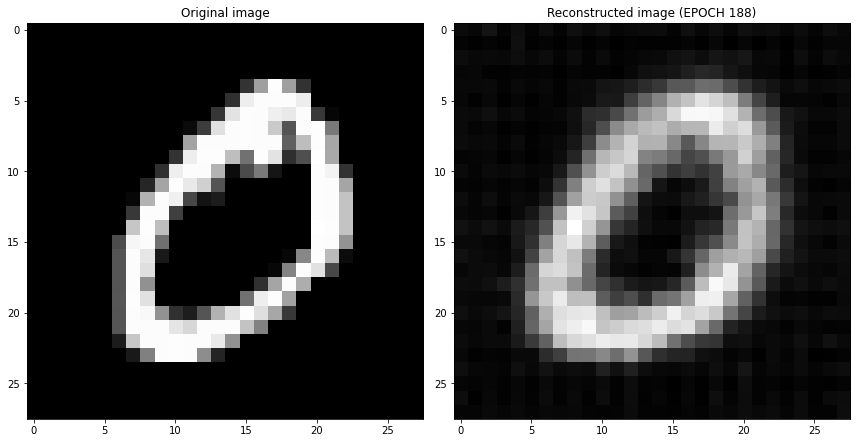

Training on hyperparameter set 2 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.092752


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.086607


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.080903


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.077676


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.077348


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.078473


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.081211


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.083690


EARLY STOPPING


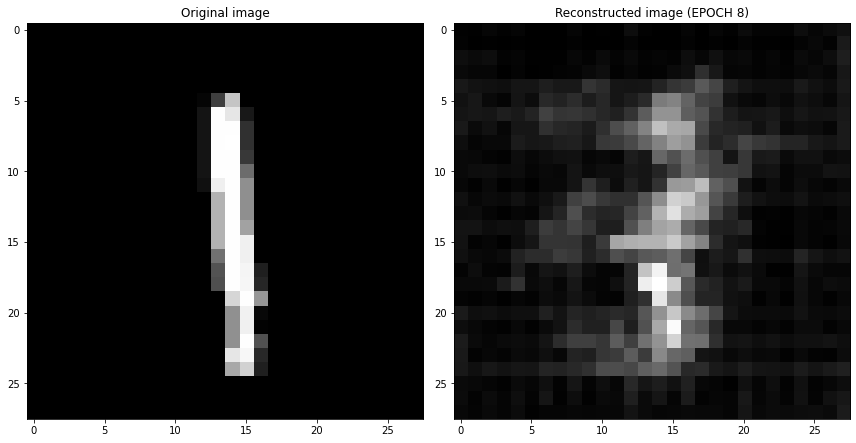

Training on hyperparameter set 2 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.086945


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.080527


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.077398


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.077626


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.082094


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.096519


EARLY STOPPING


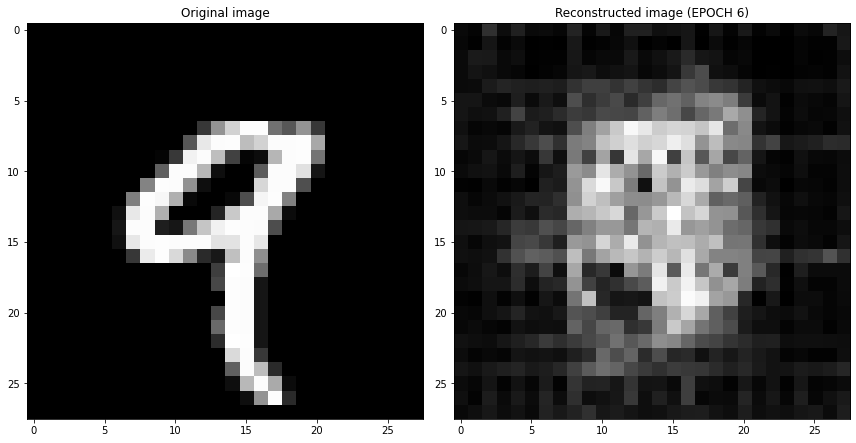

Training on hyperparameter set 2 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.083301


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.081836


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.082447


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.083271


EARLY STOPPING


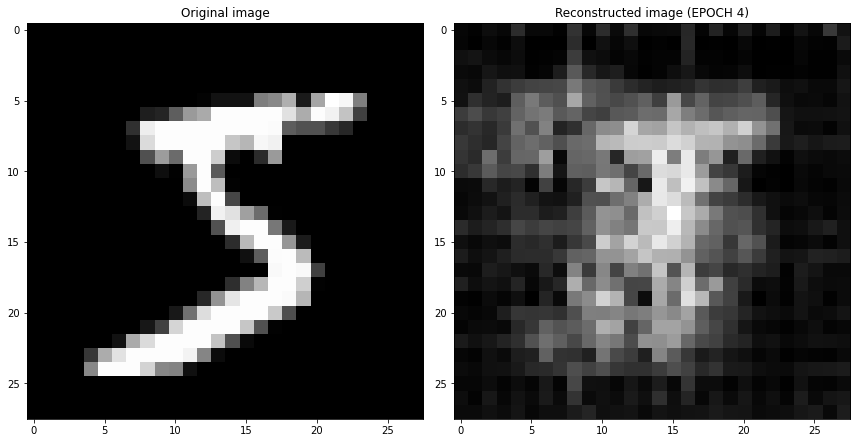

Network and parameters initialized
Training on hyperparameter set 3 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.234244


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.231804


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.229202


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.226313


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.223093


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.219504


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.215602


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.211417


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.206990


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.202422


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.197753


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.193016


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.188213


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.183285


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0

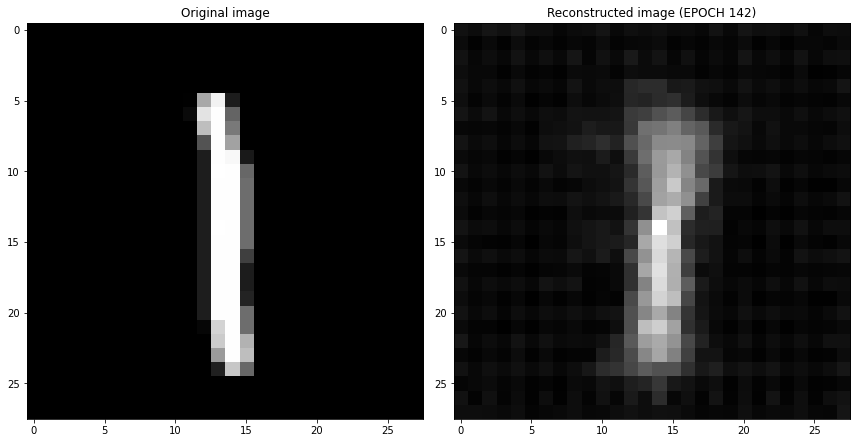

Training on hyperparameter set 3 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.115497


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.095123


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.088913


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.094455


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.105459


EARLY STOPPING


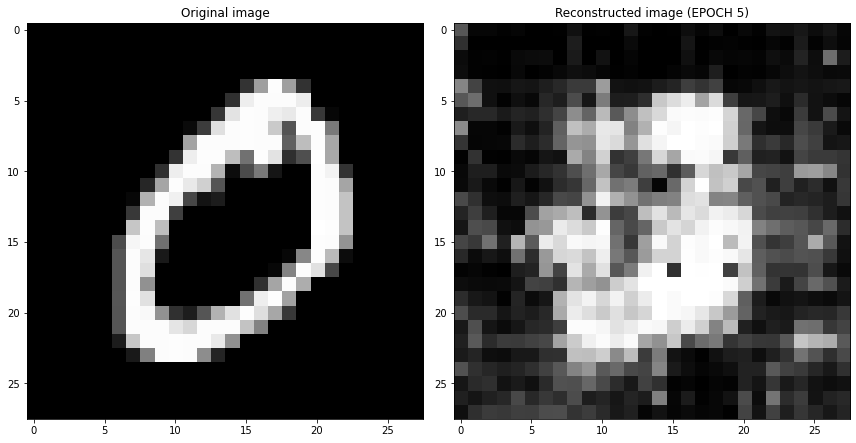

Training on hyperparameter set 3 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.089577


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.085080


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.081770


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.080180


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.082346


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.086417


EARLY STOPPING


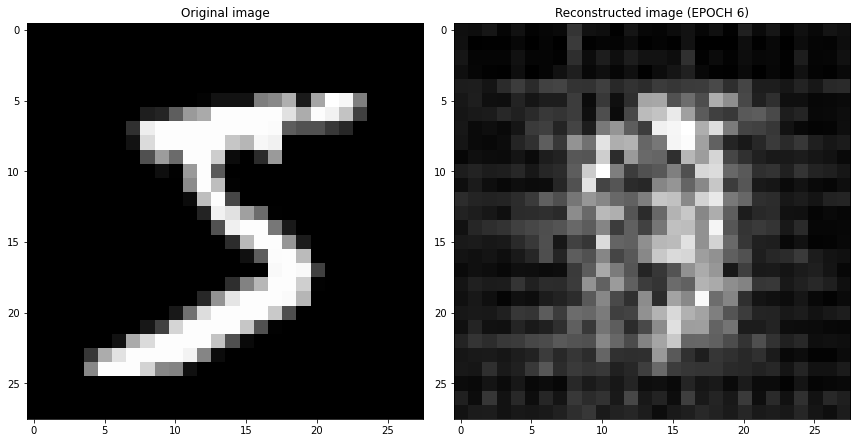

Training on hyperparameter set 3 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.083928


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.082329


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.088626


EARLY STOPPING


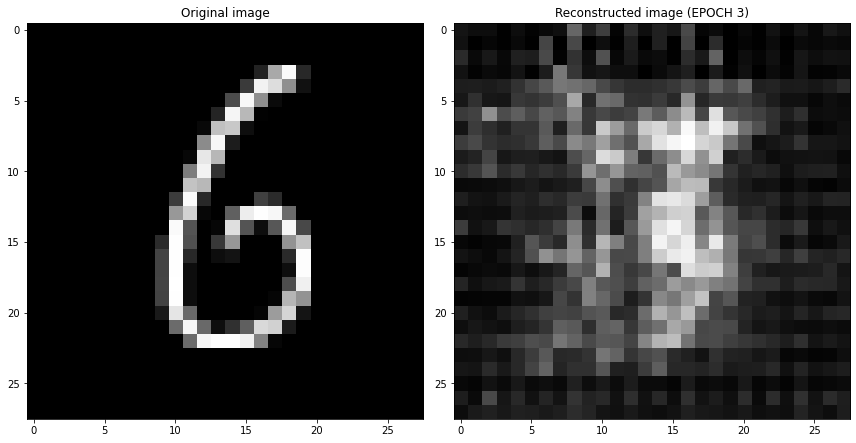

Network and parameters initialized
Training on hyperparameter set 4 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.234325


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.231883


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.229274


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.226381


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.223156


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.219564


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.215654


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.211465


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.207039


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.202478


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.197813


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.193080


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.188275


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.183352


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0

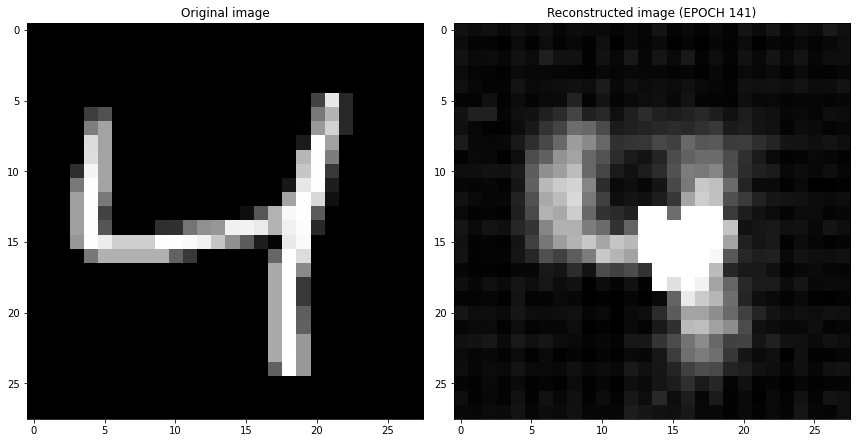

Training on hyperparameter set 4 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.103062


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.081389


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.076731


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.081237


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.088800


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.093195


EARLY STOPPING


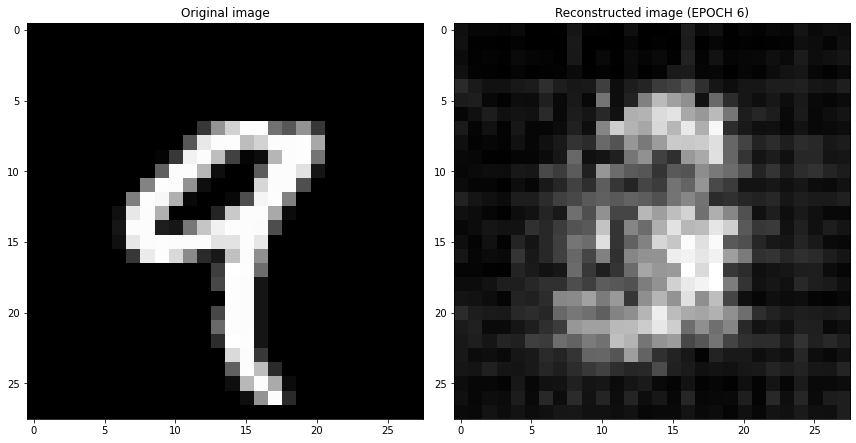

Training on hyperparameter set 4 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.090701


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.087058


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.083013


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.079532


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.078808


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.083575


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.091582


EARLY STOPPING


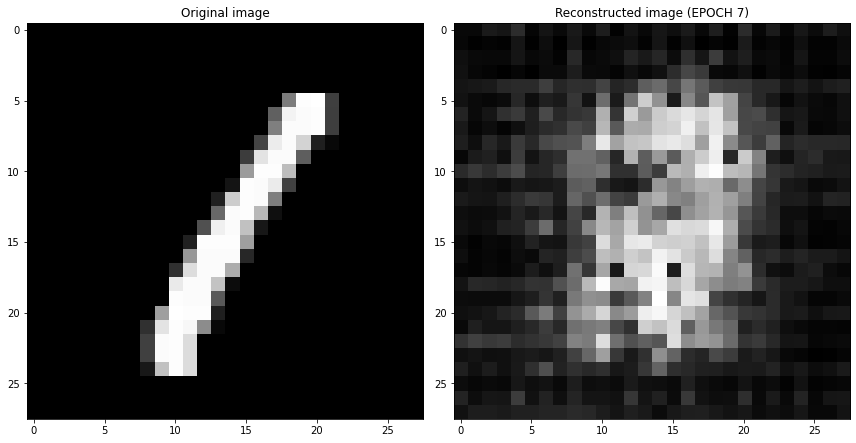

Training on hyperparameter set 4 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.085923


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.085529


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.088682


EARLY STOPPING


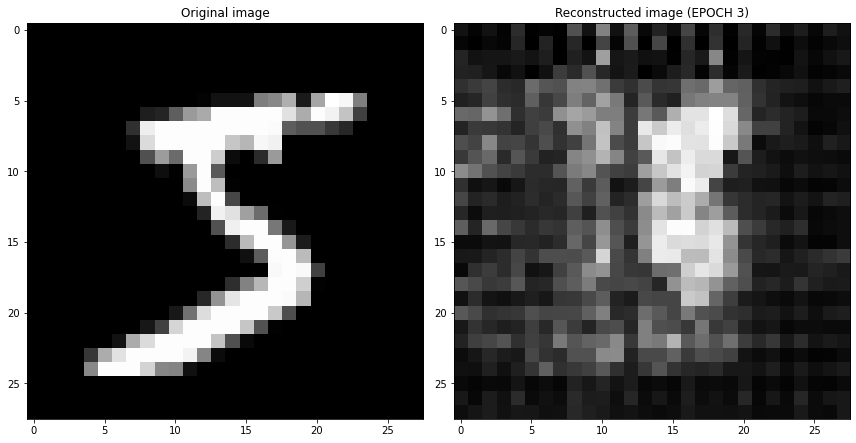

Network and parameters initialized
Training on hyperparameter set 5 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.229973


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.226759


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.223077


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.219335


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.215415


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.211089


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.206310


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.201279


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.196149


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.191148


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.186211


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.181255


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.175935


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.170490


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0

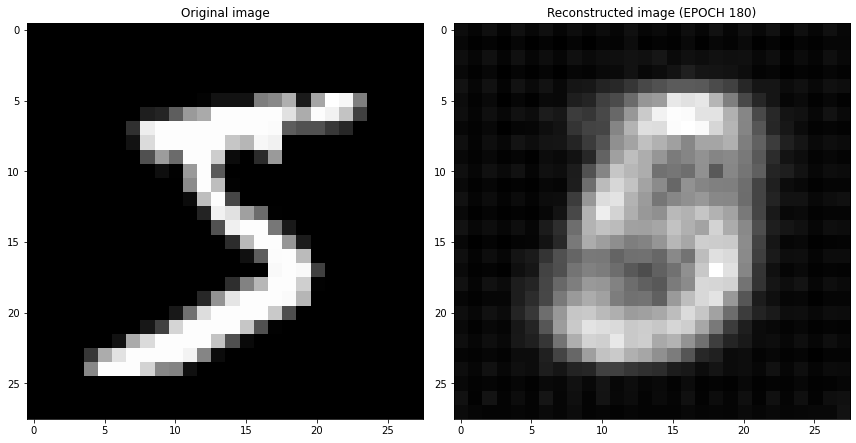

Training on hyperparameter set 5 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.099422


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.089416


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.082224


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.079242


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.083086


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.094203


EARLY STOPPING


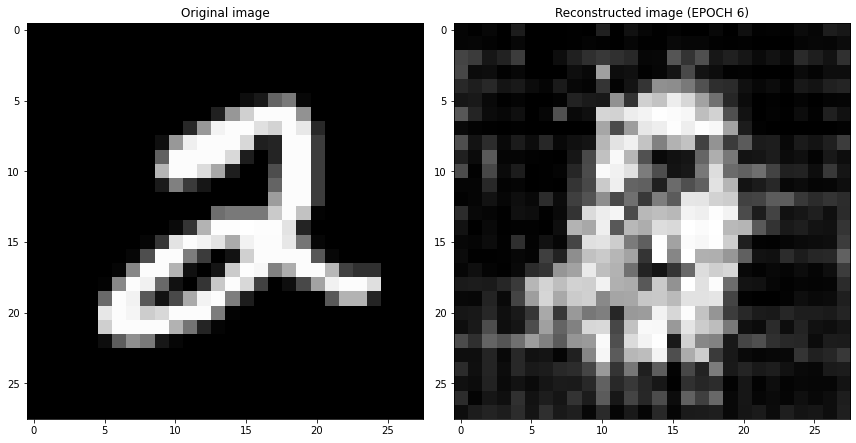

Training on hyperparameter set 5 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.099490


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.093018


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.097542


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.107815


EARLY STOPPING


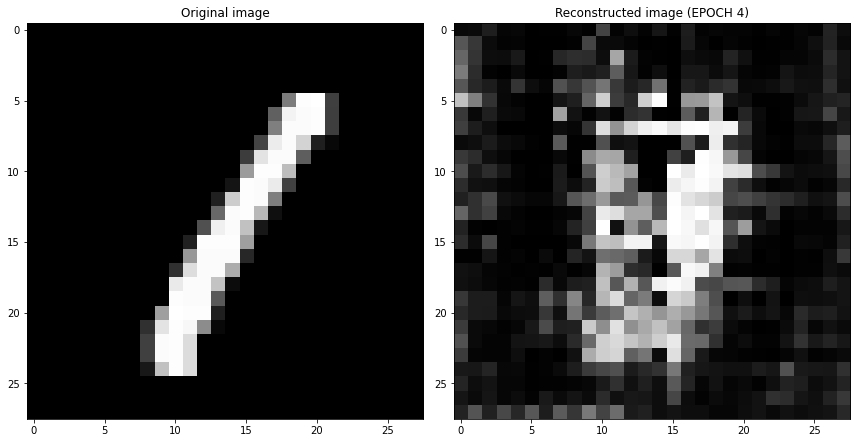

Training on hyperparameter set 5 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.095413


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.089282


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.082943


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.078219


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.075586


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.075070


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.073771


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.071279


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.069912


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.070412


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.073629


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.076329


EARLY STOPPING


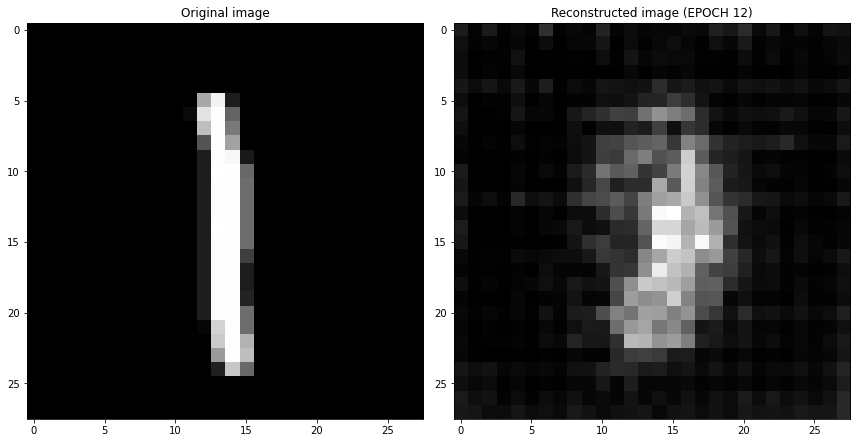

Network and parameters initialized
Training on hyperparameter set 6 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.230001


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.226783


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.223095


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.219349


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.215425


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.211093


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.206303


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.201259


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.196115


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.191104


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.186163


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.181204


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.175878


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.170428


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0

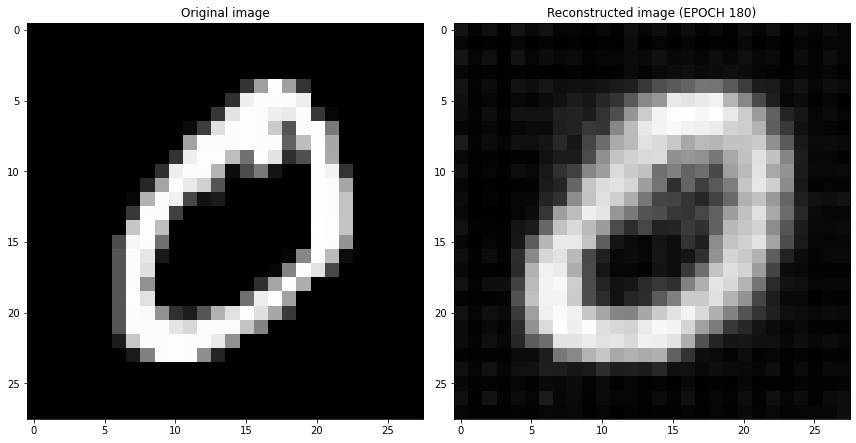

Training on hyperparameter set 6 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.099145


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.089491


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.082940


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.080243


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.083707


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.093367


EARLY STOPPING


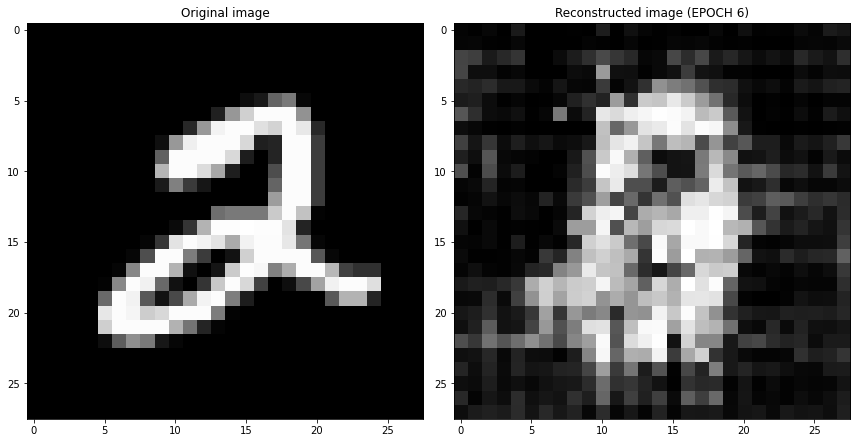

Training on hyperparameter set 6 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.098793


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.092359


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.096748


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.105931


EARLY STOPPING


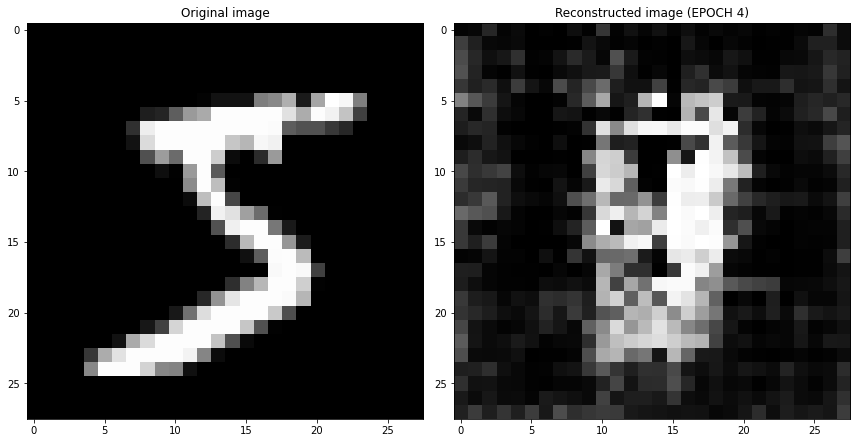

Training on hyperparameter set 6 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.096046


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.090361


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.084145


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.079513


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.076427


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.074884


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.073234


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.071209


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.069956


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.069164


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.072262


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.074629


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.073171


EARLY STOPPING


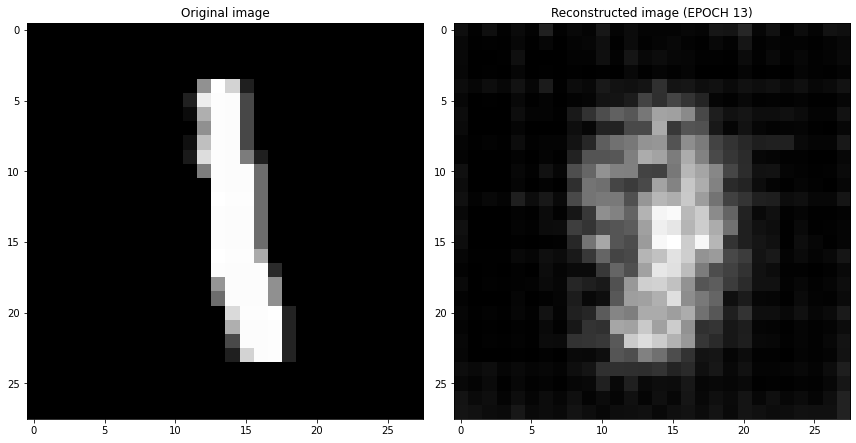

Network and parameters initialized
Training on hyperparameter set 7 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.196557


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.195107


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.193421


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.191444


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.189181


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.186527


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.183386


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.179755


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.175667


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.171309


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.166580


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.161672


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.156571


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.151591


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0

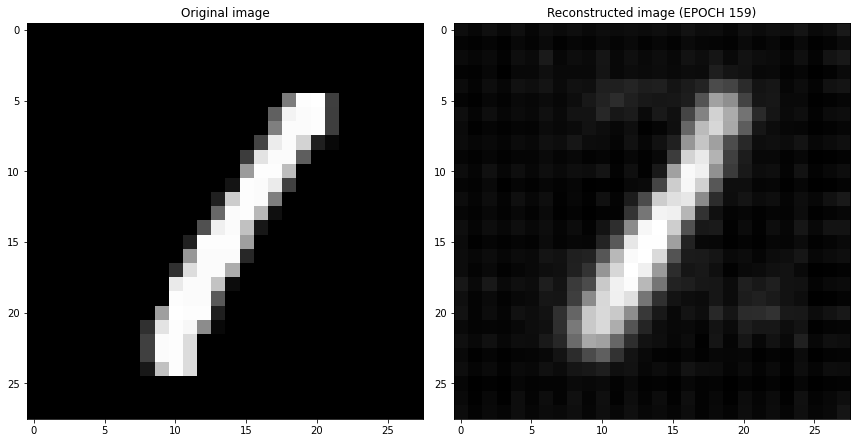

Training on hyperparameter set 7 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.093495


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.084702


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.083854


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.084375


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.087404


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.097358


EARLY STOPPING


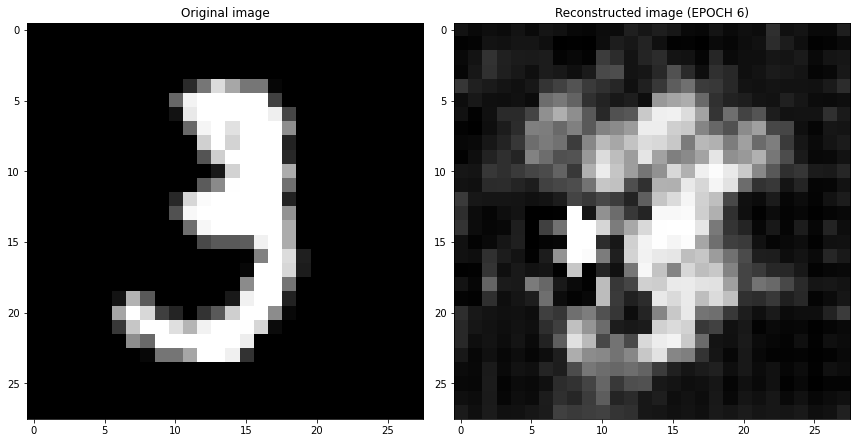

Training on hyperparameter set 7 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.087295


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.084508


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.091803


EARLY STOPPING


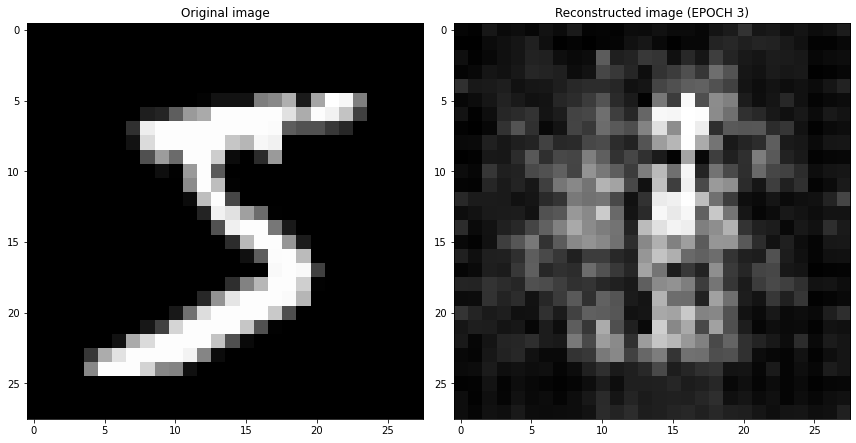

Training on hyperparameter set 7 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.087353


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.084939


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.083919


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.090754


EARLY STOPPING


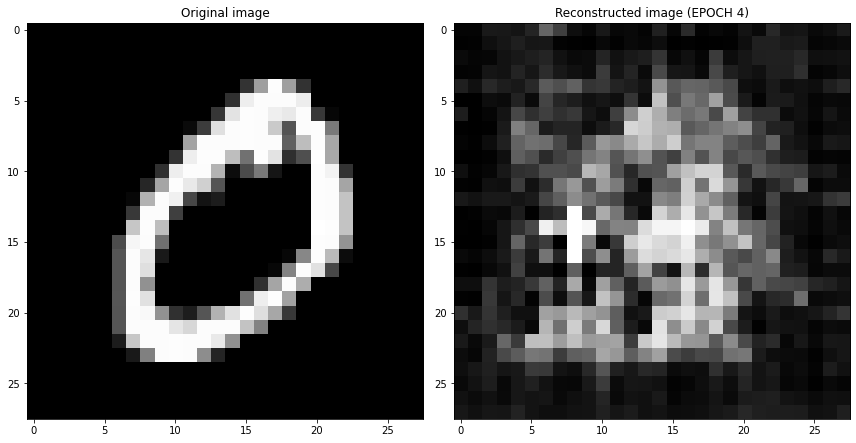

Network and parameters initialized
Training on hyperparameter set 8 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.196545


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.195094


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.193405


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.191427


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.189167


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.186511


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.183364


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.179722


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.175619


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.171246


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.166507


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.161596


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.156488


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.151510


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0

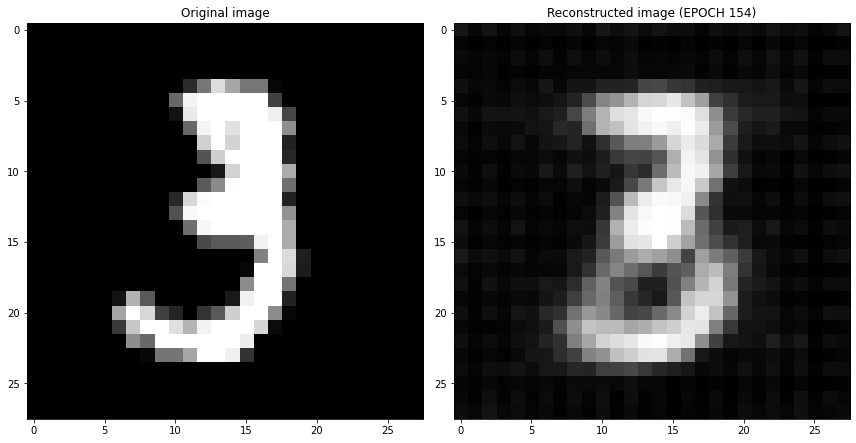

Training on hyperparameter set 8 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.093088


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.081628


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.091388


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.105559


EARLY STOPPING


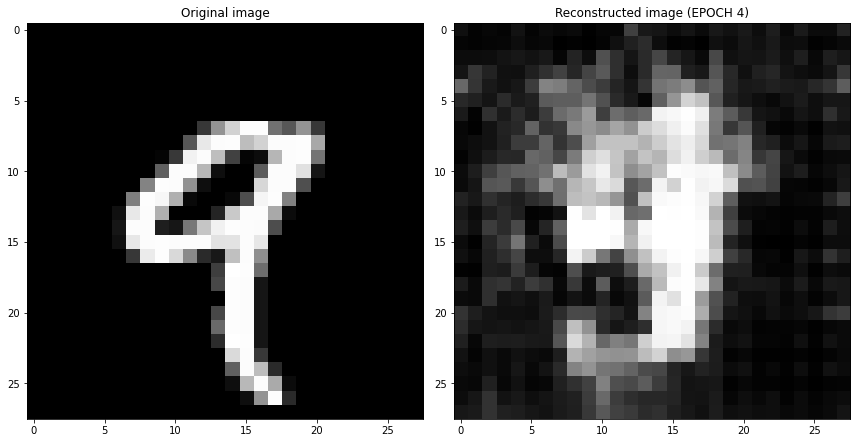

Training on hyperparameter set 8 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.087540


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.084523


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.083580


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.089515


EARLY STOPPING


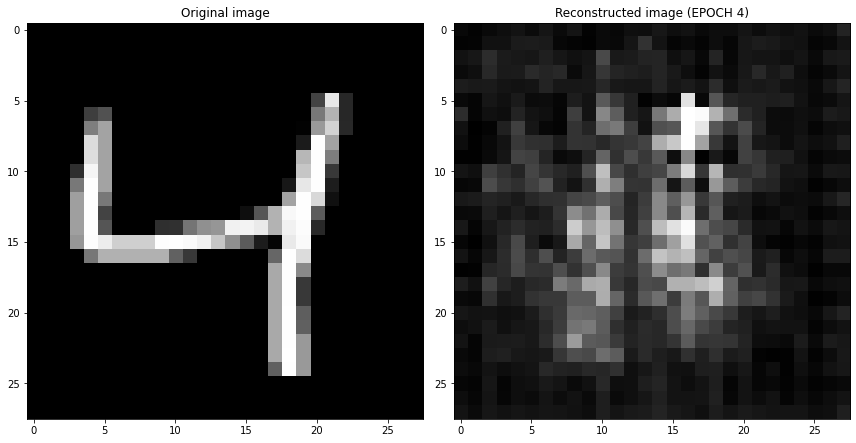

Training on hyperparameter set 8 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.089943


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.084760


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.082262


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.083197


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.086301


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.090763


EARLY STOPPING


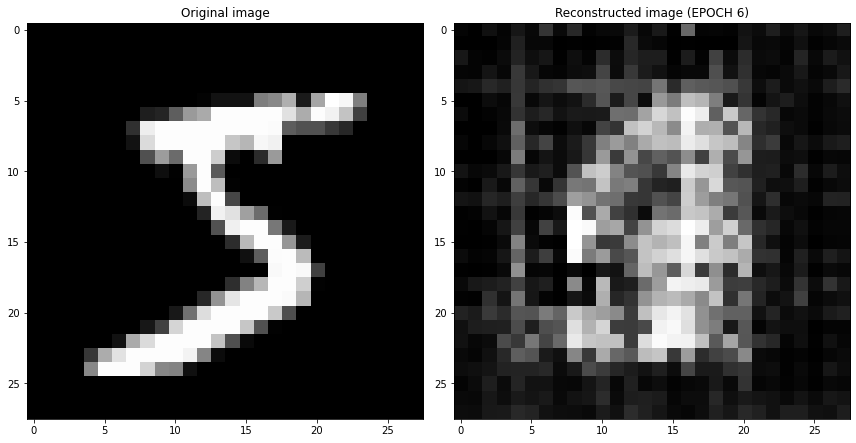

Network and parameters initialized
Training on hyperparameter set 9 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.196562


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.195140


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.193461


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.191472


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.189171


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.186488


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.183365


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.179783


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.175867


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.171691


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.167189


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.162537


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.157727


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.153094


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0

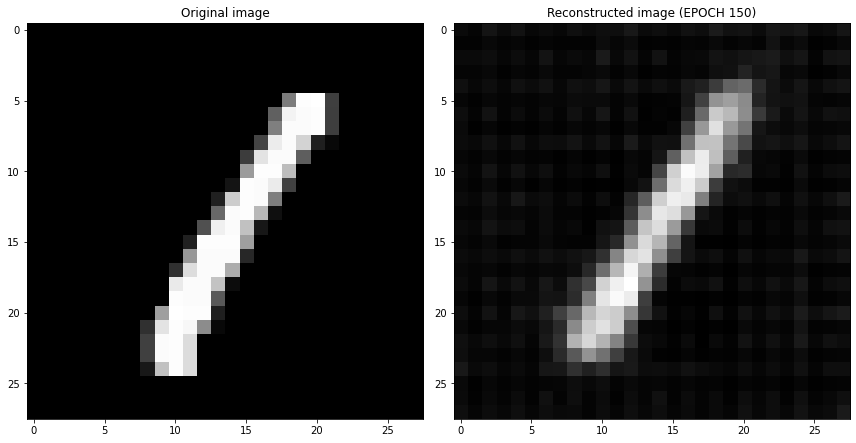

Training on hyperparameter set 9 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.096396


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.088878


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.087102


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.088244


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.088680


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.091776


EARLY STOPPING


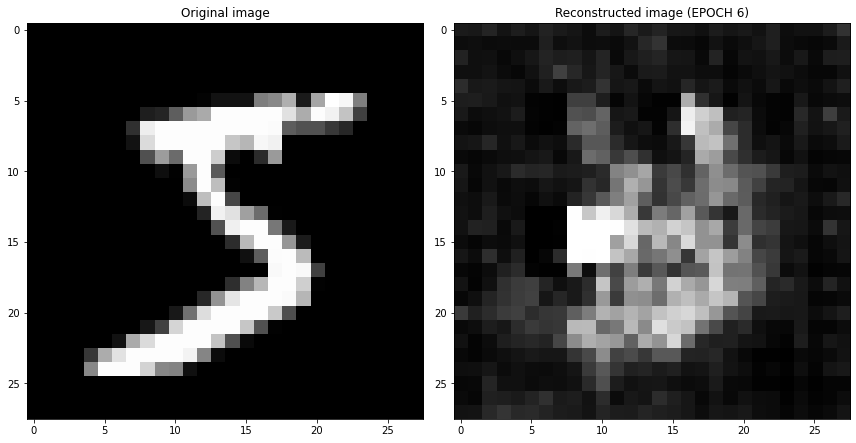

Training on hyperparameter set 9 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.089338


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.085610


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.083736


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.082599


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.082020


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.086968


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.096704


EARLY STOPPING


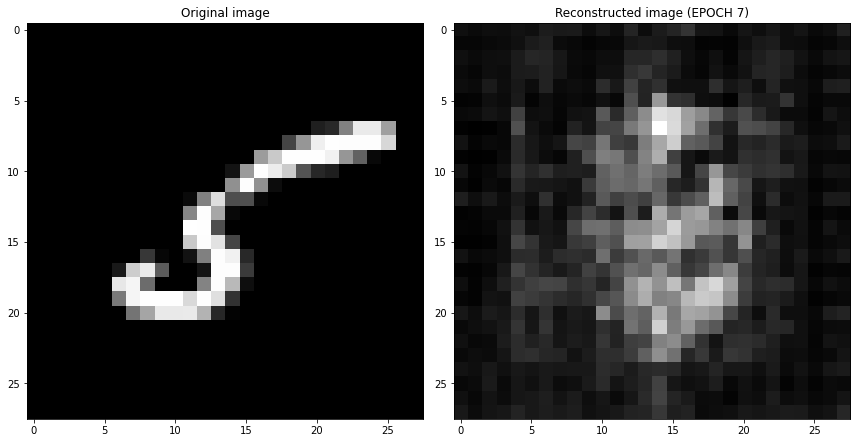

Training on hyperparameter set 9 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.087178


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.082784


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.084148


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.093225


EARLY STOPPING


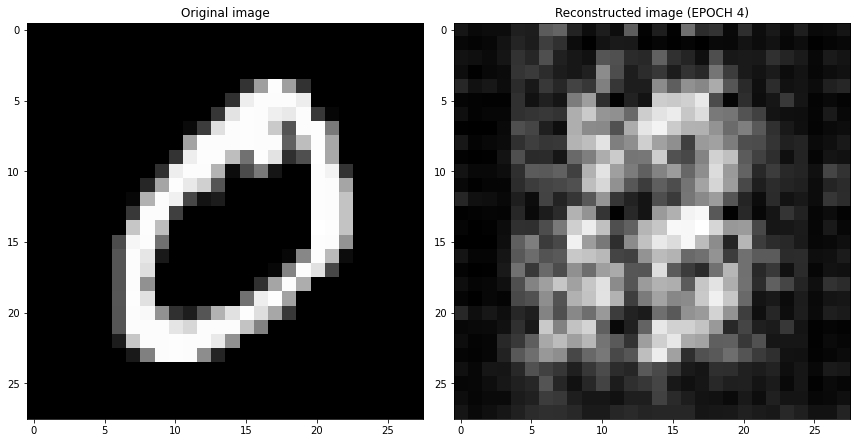

Network and parameters initialized
Training on hyperparameter set 10 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.196588


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.195164


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.193479


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.191482


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.189176


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.186478


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.183331


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.179727


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.175788


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.171604


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.167116


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.162478


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.157682


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.153053


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 

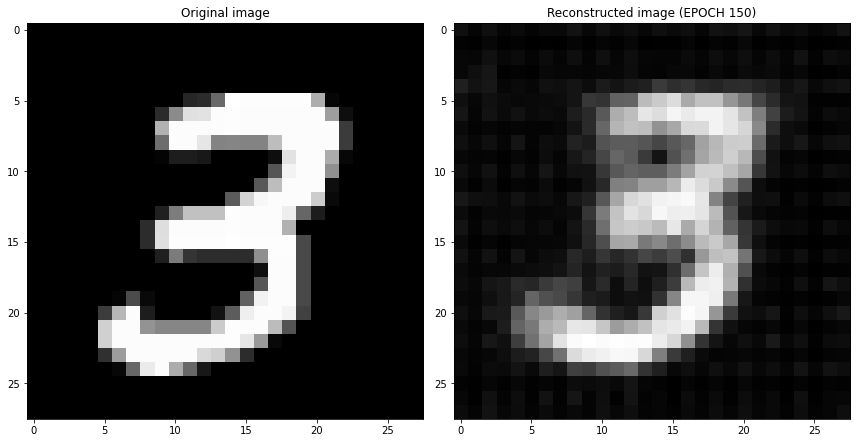

Training on hyperparameter set 10 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.096217


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.092953


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.091566


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.093402


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.099102


EARLY STOPPING


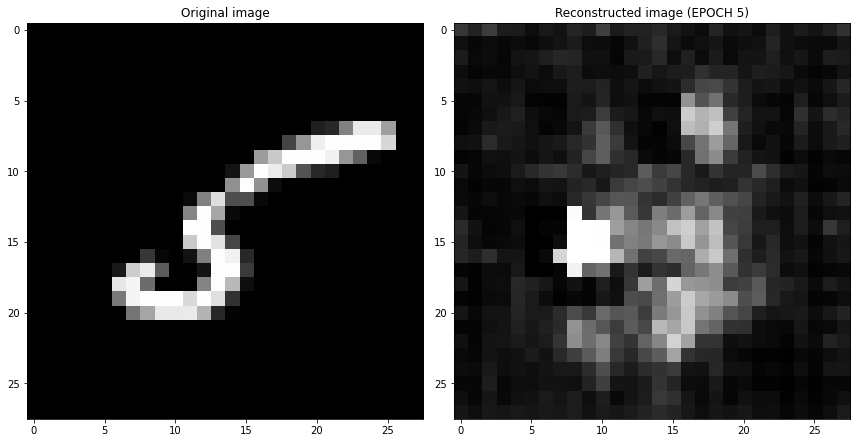

Training on hyperparameter set 10 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.091391


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.086838


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.082161


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.080267


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.081574


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.083611


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.085242


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.088705


EARLY STOPPING


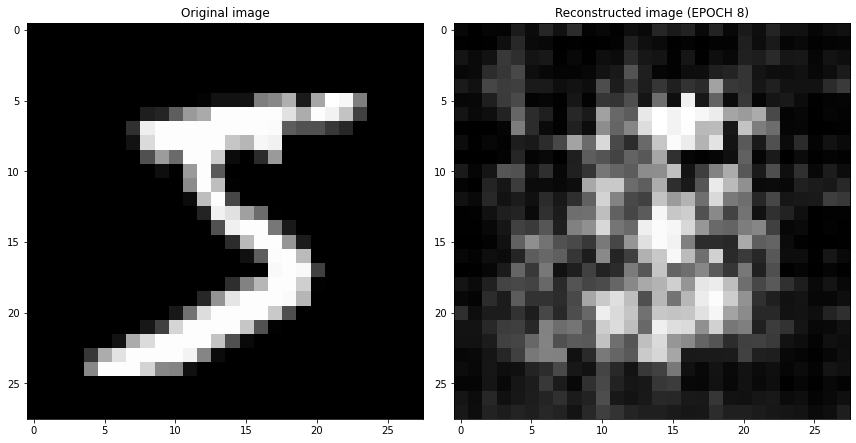

Training on hyperparameter set 10 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.086867


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.082728


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.079184


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.077526


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.077832


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.078368


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.078940


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.080164


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.082592


EARLY STOPPING


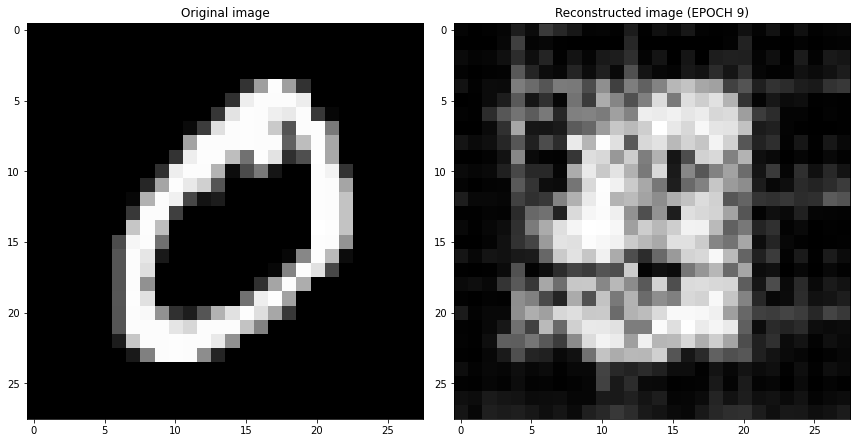

Network and parameters initialized
Training on hyperparameter set 11 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.195099


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.191727


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.188220


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.184525


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.180588


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.176353


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.171924


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.167330


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.162562


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.157880


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.153045


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.148333


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.143693


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.139302


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 

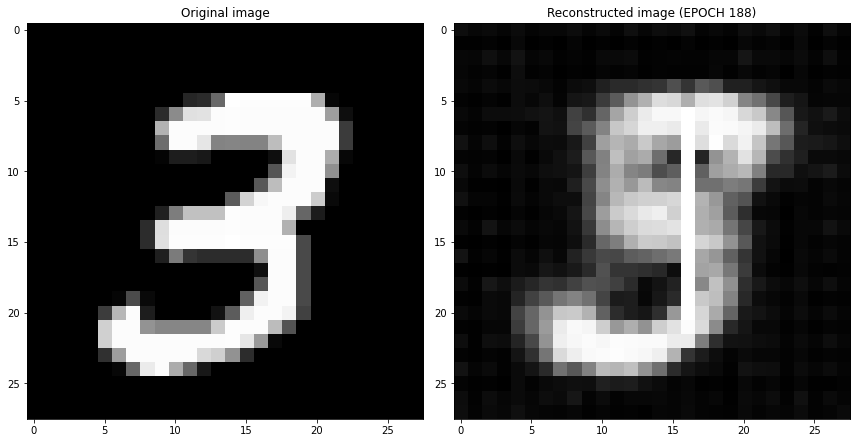

Training on hyperparameter set 11 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.087105


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.084500


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.086107


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.085940


EARLY STOPPING


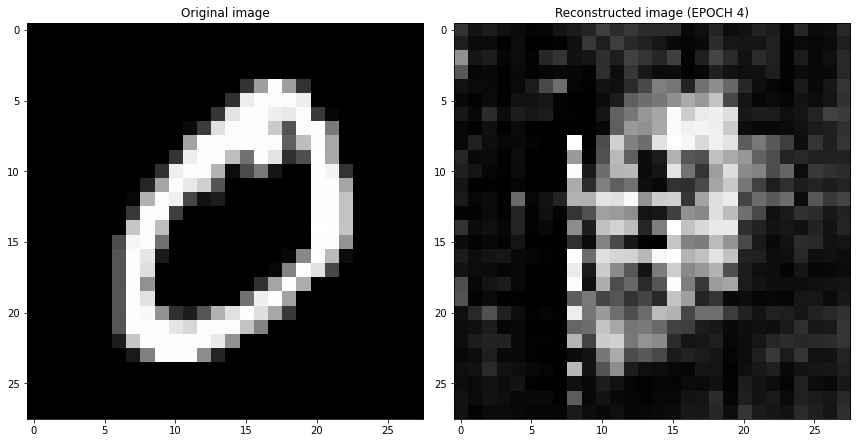

Training on hyperparameter set 11 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.096394


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.091334


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.085176


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.078365


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.072552


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.070198


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.073125


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.078336


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.083117


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.092871


EARLY STOPPING


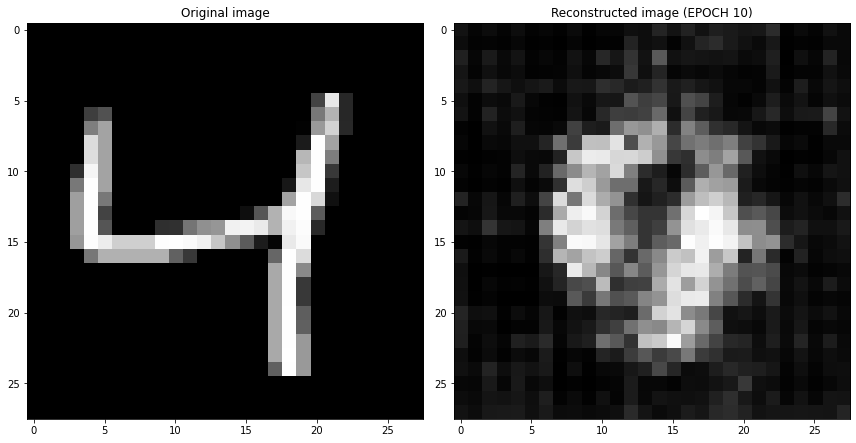

Training on hyperparameter set 11 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.094020


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.084308


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.078103


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.077544


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.079639


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.082309


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.086965


EARLY STOPPING


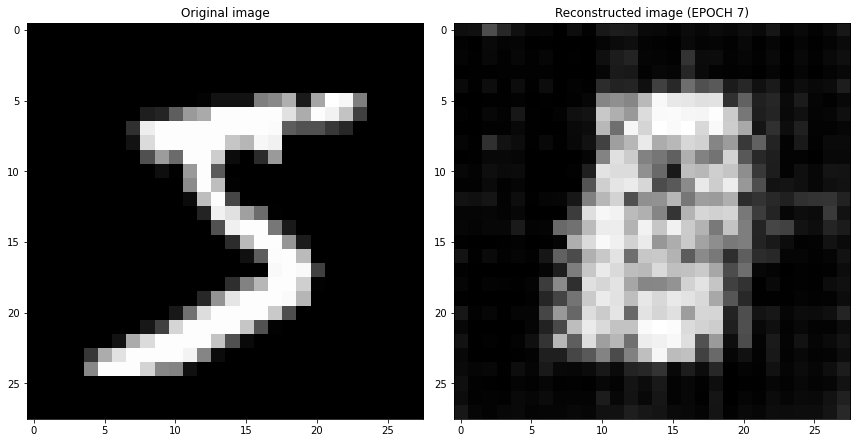

Network and parameters initialized
Training on hyperparameter set 12 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.195057


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.191685


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.188176


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.184482


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.180549


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.176320


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.171904


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.167331


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.162601


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.157984


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.153243


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.148648


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.144161


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.139963


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 

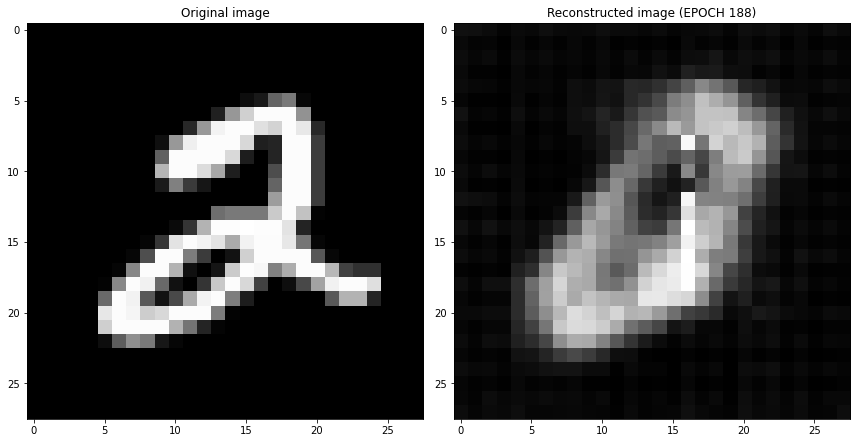

Training on hyperparameter set 12 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.087096


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.084098


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.085567


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.085690


EARLY STOPPING


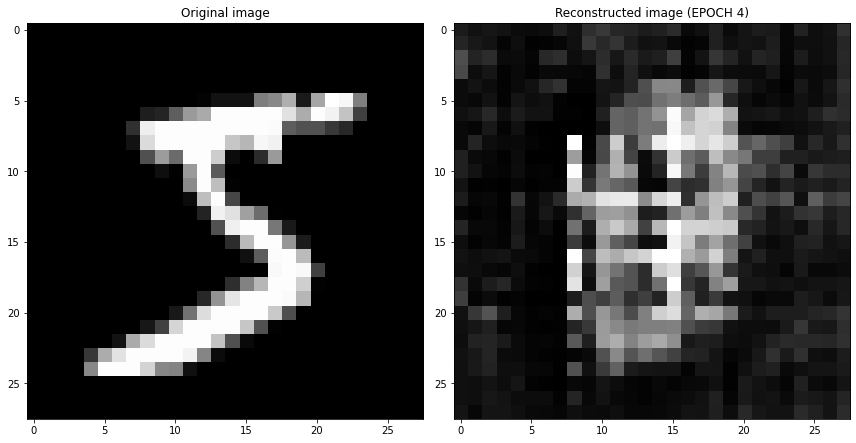

Training on hyperparameter set 12 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.097157


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.092037


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.085752


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.079158


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.073460


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.070322


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.073903


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.081646


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.085736


EARLY STOPPING


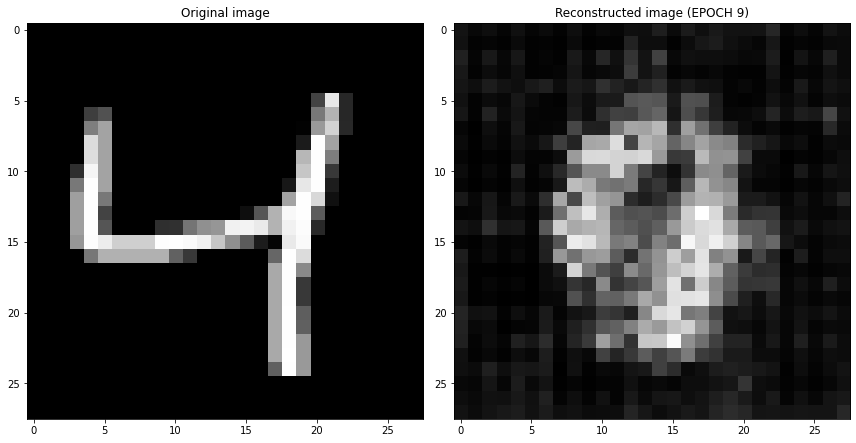

Training on hyperparameter set 12 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.094079


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.085533


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.078647


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.077561


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.080004


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.083657


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.087374


EARLY STOPPING


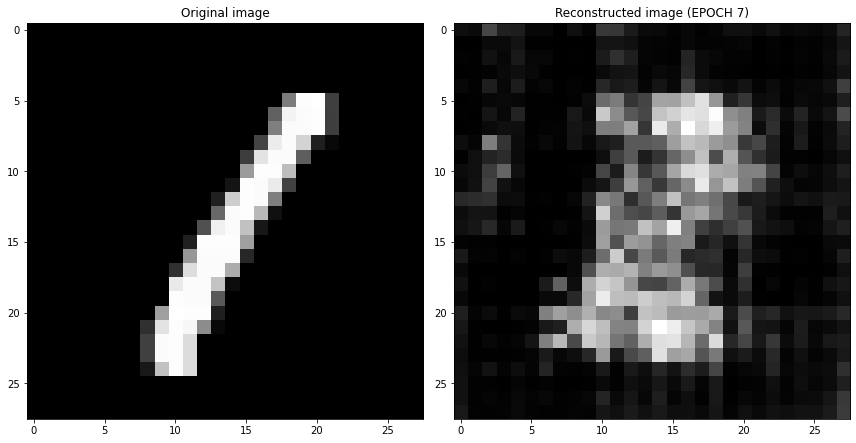

Network and parameters initialized
Training on hyperparameter set 13 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.231664


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.230366


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.228891


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.227041


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.224694


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.221701


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.217949


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.213390


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.208061


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.202039


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.195507


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.188810


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.181943


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.175148


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 

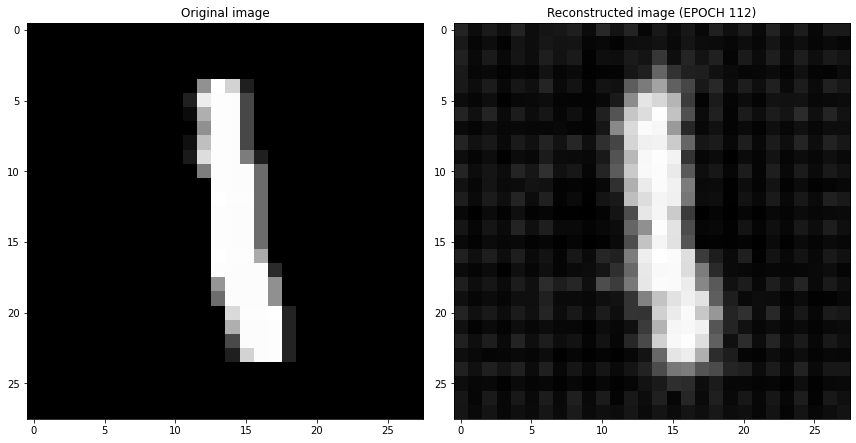

Training on hyperparameter set 13 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.096843


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.091378


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.086286


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.088871


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.110328


EARLY STOPPING


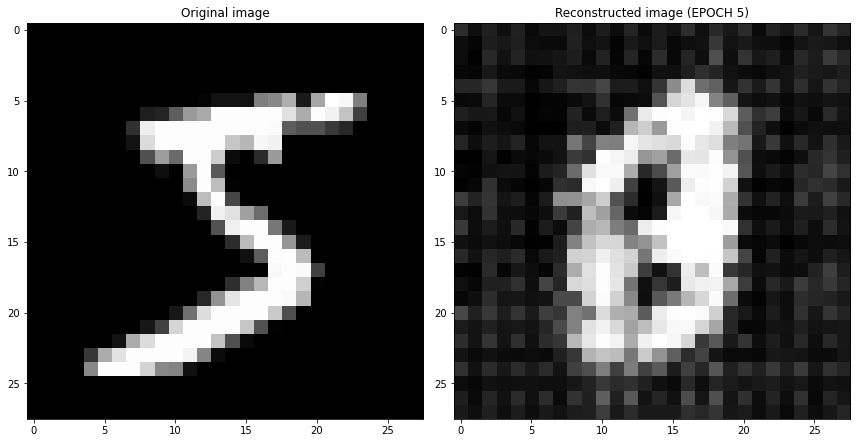

Training on hyperparameter set 13 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.094066


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.093322


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.090958


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.084014


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.082159


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.097005


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.120218


EARLY STOPPING


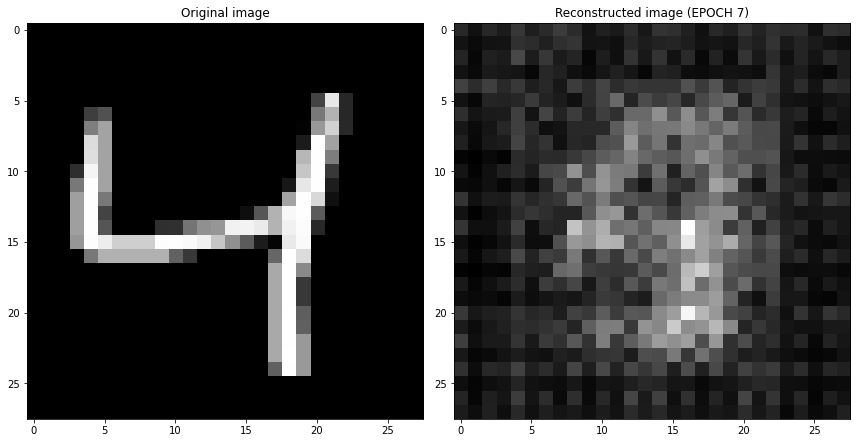

Training on hyperparameter set 13 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.094184


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.091866


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.087370


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.080412


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.075165


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.075939


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.081373


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.088394


EARLY STOPPING


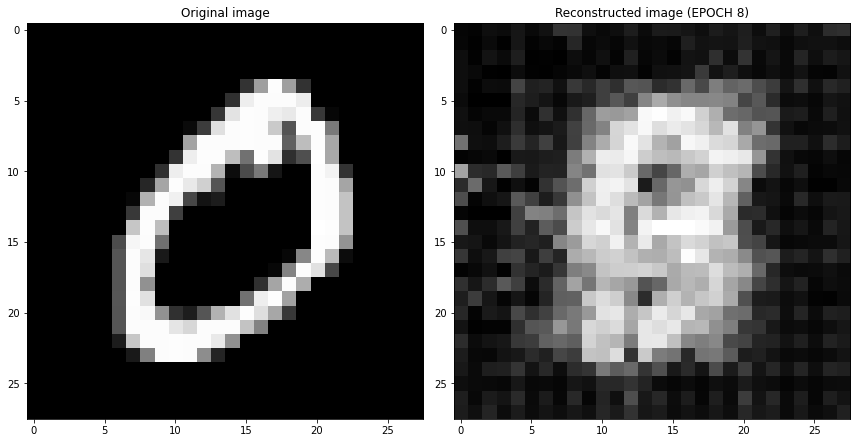

Network and parameters initialized
Training on hyperparameter set 14 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.231660


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.230366


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.228898


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.227054


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.224717


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.221740


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.218007


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.213461


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.208134


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.202103


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.195547


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.188802


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.181883


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.175049


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 

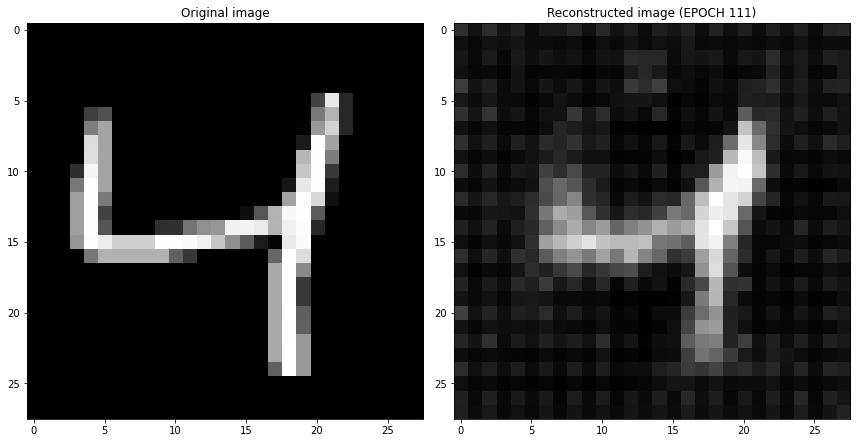

Training on hyperparameter set 14 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.097741


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.093093


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.087669


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.086444


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.099504


EARLY STOPPING


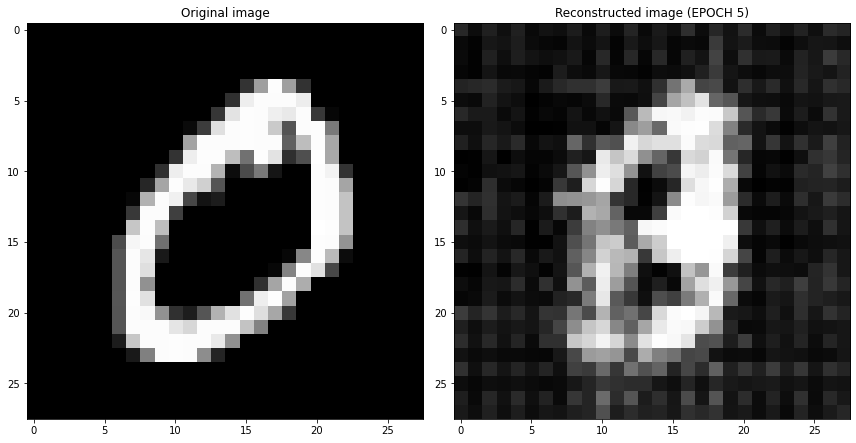

Training on hyperparameter set 14 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.094274


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.093315


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.091594


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.085247


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.079509


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.089265


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.111110


EARLY STOPPING


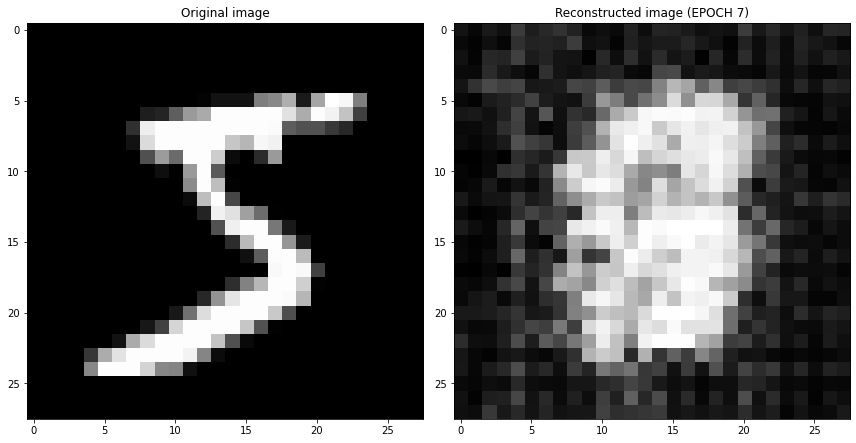

Training on hyperparameter set 14 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.094680


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.093157


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.089793


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.084117


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.077667


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.073878


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.073589


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.074998


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.077023


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.078463


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.078623


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.077494


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.075565


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.073148


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.070739


EPOCH 16/500


	 VALIDAT

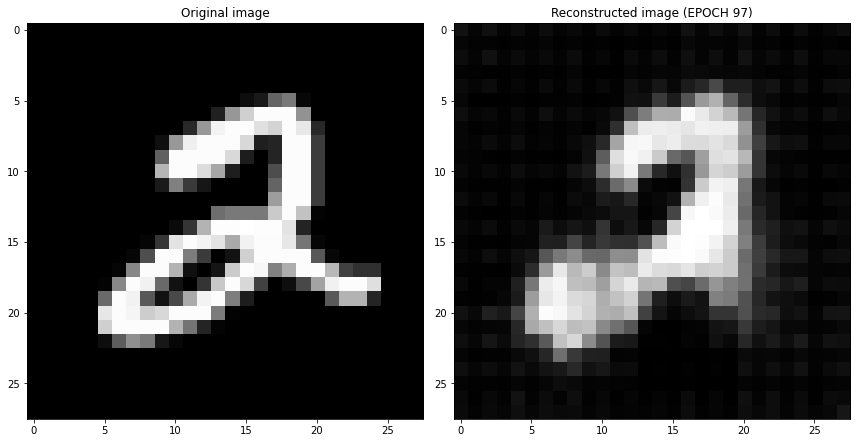

Network and parameters initialized
Training on hyperparameter set 15 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.231690


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.230335


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.228773


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.226817


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.224418


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.221396


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.217612


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.213019


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.207693


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.201662


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.194966


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.187932


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.180697


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.173531


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 

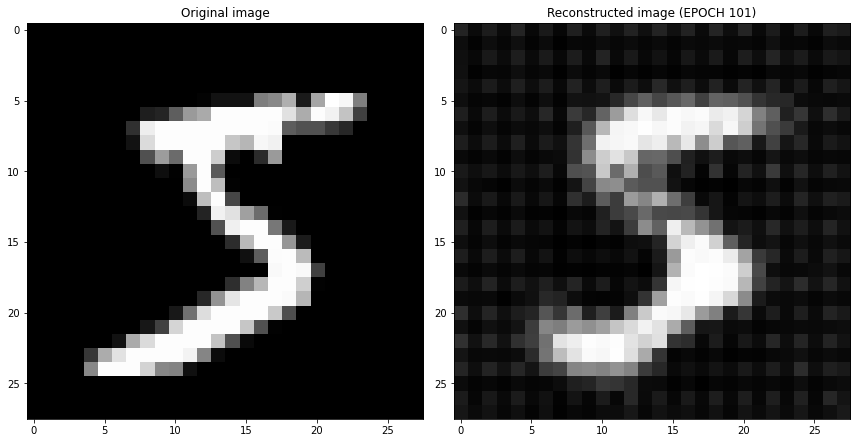

Training on hyperparameter set 15 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.097500


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.088928


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.080083


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.082041


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.092183


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.107758


EARLY STOPPING


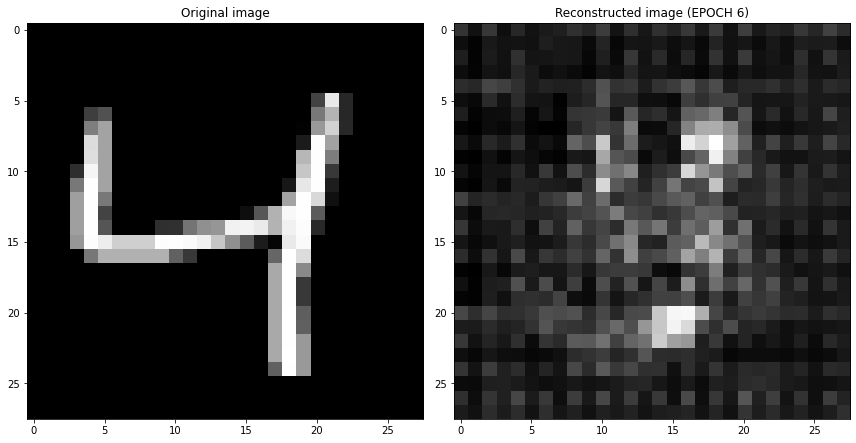

Training on hyperparameter set 15 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.096440


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.095227


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.091817


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.085705


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.083193


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.097364


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.122825


EARLY STOPPING


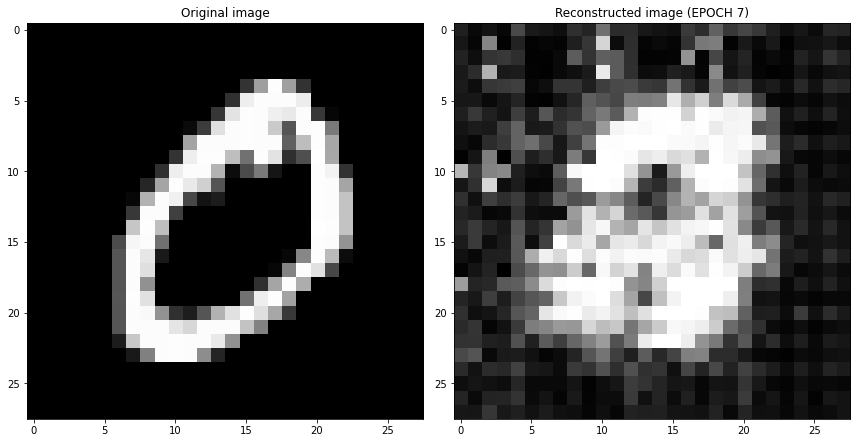

Training on hyperparameter set 15 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.095379


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.093438


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.089255


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.082412


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.075985


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.076897


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.084710


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.094448


EARLY STOPPING


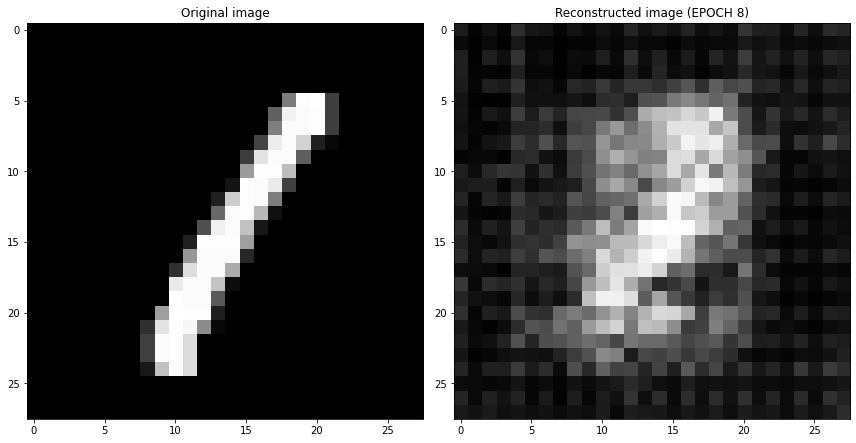

Network and parameters initialized
Training on hyperparameter set 16 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.231648


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.230294


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.228729


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.226770


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.224367


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.221333


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.217540


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.212932


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.207593


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.201549


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.194833


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.187762


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.180503


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.173330


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 

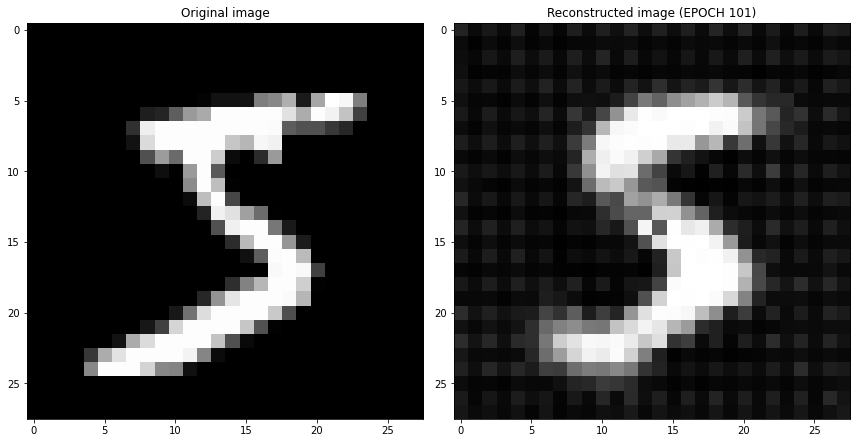

Training on hyperparameter set 16 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.099130


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.092101


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.082711


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.081781


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.089003


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.101924


EARLY STOPPING


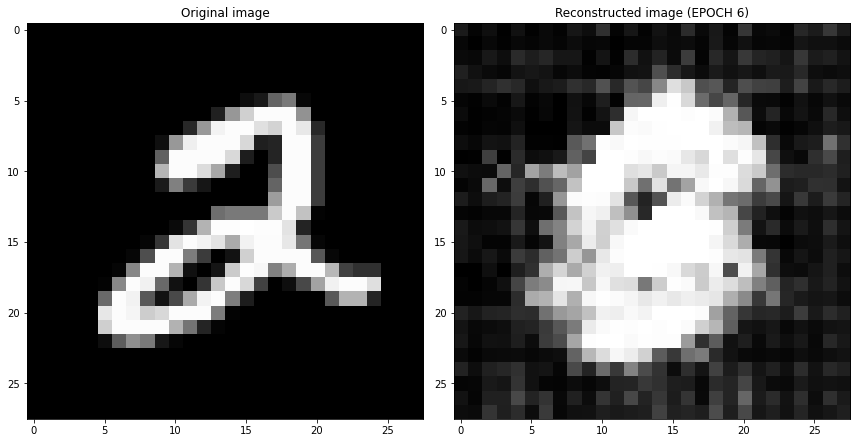

Training on hyperparameter set 16 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.094957


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.092467


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.089390


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.085392


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.078953


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.081528


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.097917


EARLY STOPPING


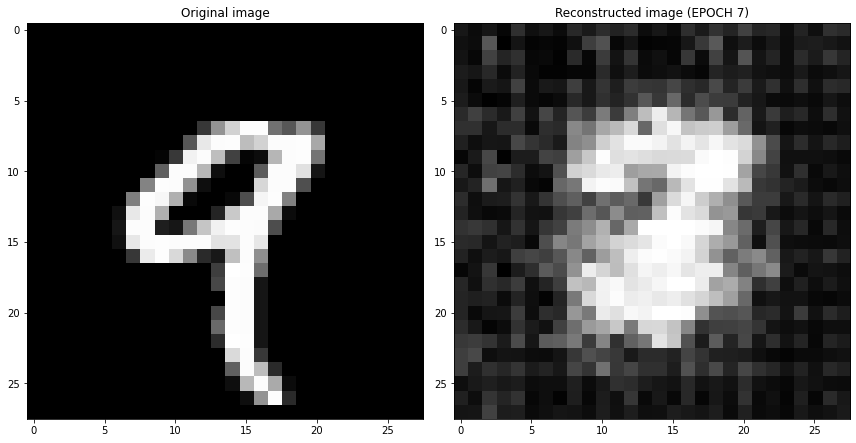

Training on hyperparameter set 16 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.095925


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.094633


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.091186


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.085577


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.078523


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.073667


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.075706


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.082377


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.087988


EARLY STOPPING


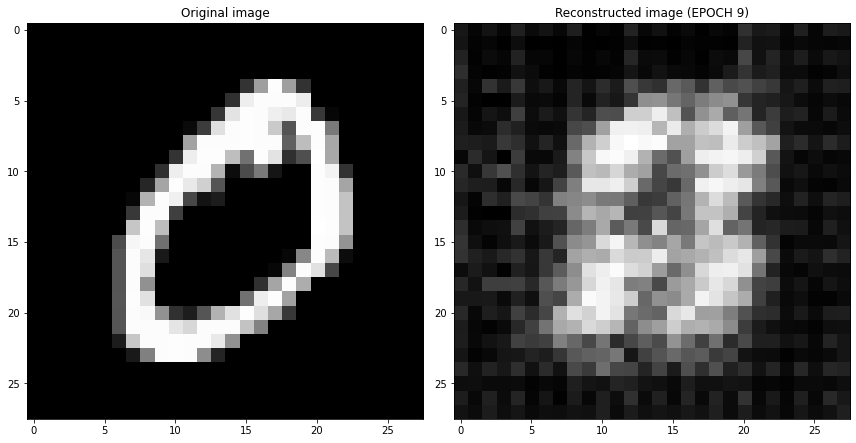

Network and parameters initialized
Training on hyperparameter set 17 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.233563


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.229431


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.224967


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.220144


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.214948


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.209323


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.203695


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.197545


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.190808


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.183799


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.176120


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.168099


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.159036


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.151355


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 

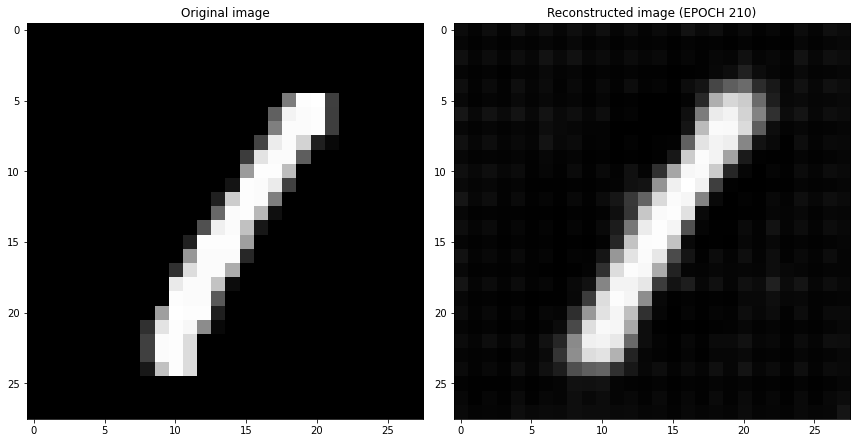

Training on hyperparameter set 17 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.099943


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.091121


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.084724


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.079797


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.070342


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.062691


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.058017


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.056022


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.057971


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.063692


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.066953


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.064124


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.059969


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.057860


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.061113


EPOCH 16/500


	 VALIDAT

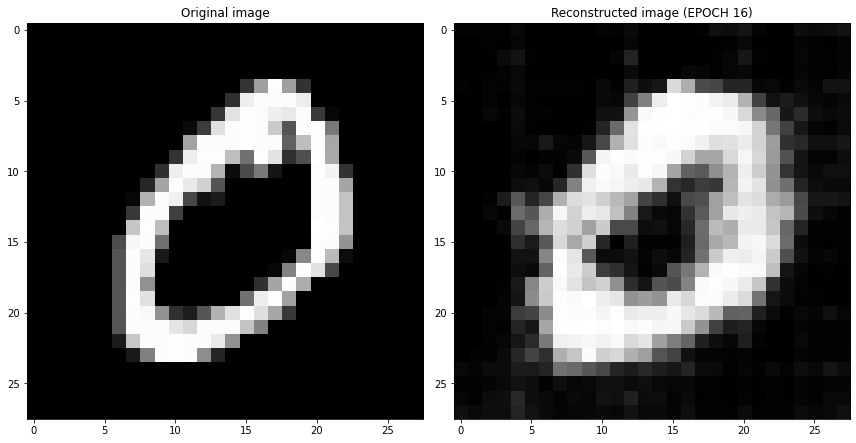

Training on hyperparameter set 17 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.102593


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.097536


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.087235


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.072024


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.062941


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.060749


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.060575


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.062796


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.064653


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.065409


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.068286


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.071164


EARLY STOPPING


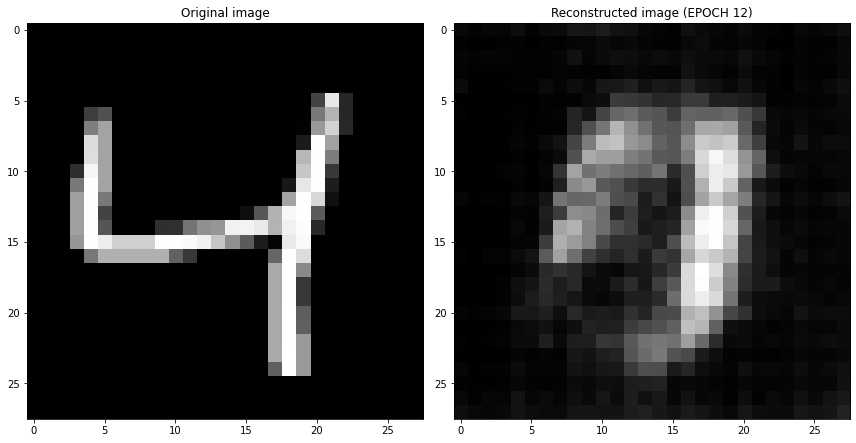

Training on hyperparameter set 17 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.104310


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.098773


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.088305


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.075138


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.066573


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.063207


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.062347


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.062340


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.063253


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.064585


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.064859


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.064277


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.061822


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.059369


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.057332


EPOCH 16/500


	 VALIDAT

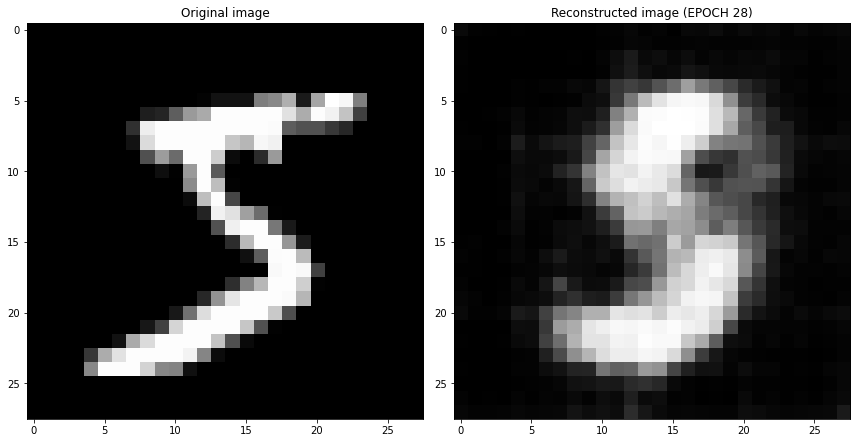

Network and parameters initialized
Training on hyperparameter set 18 out of 18
Training on fold: 0
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.233536


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.229408


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.224947


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.220127


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.214938


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.209333


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.203754


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.197688


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.191059


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.184169


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.176590


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.168659


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.159685


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.152122


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 

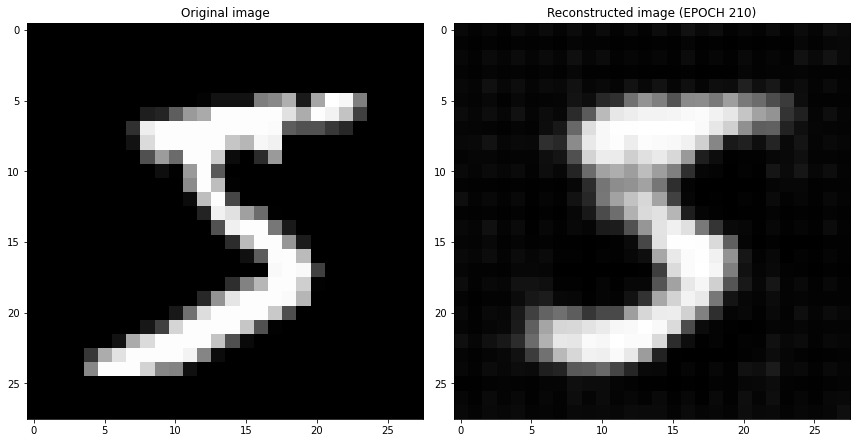

Training on hyperparameter set 18 out of 18
Training on fold: 1
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.100593


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.092227


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.086113


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.081846


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.072910


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.064297


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.058548


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.055856


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.056921


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.060605


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.063020


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.061718


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.059420


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.057701


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.059771


EPOCH 16/500


	 VALIDAT

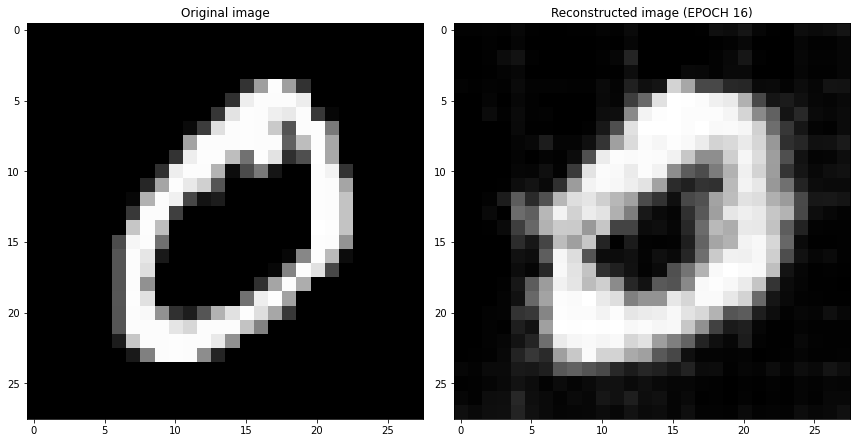

Training on hyperparameter set 18 out of 18
Training on fold: 2
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.102822


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.098035


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.087552


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.072529


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.062905


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.060934


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.061038


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.063570


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.065448


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.065507


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.067268


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.069429


EARLY STOPPING


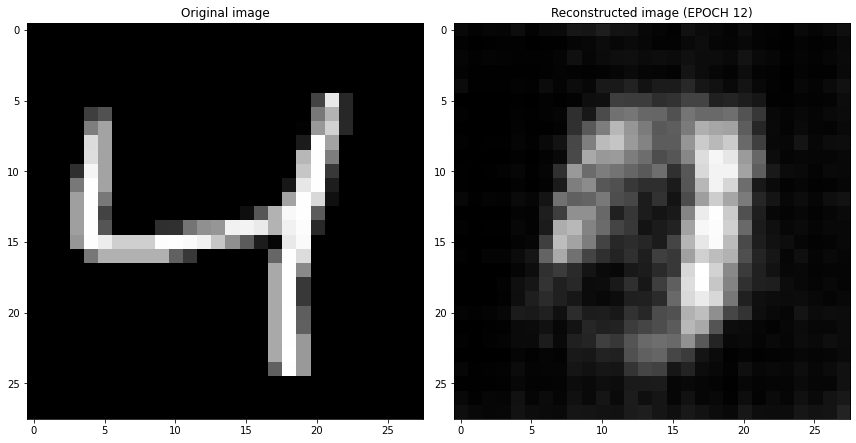

Training on hyperparameter set 18 out of 18
Training on fold: 3
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.104081


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.098884


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.089115


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.075992


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.066576


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.062681


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.061439


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.060719


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.060256


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.060818


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.061517


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.061664


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.059640


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.057223


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.055171


EPOCH 16/500


	 VALIDAT

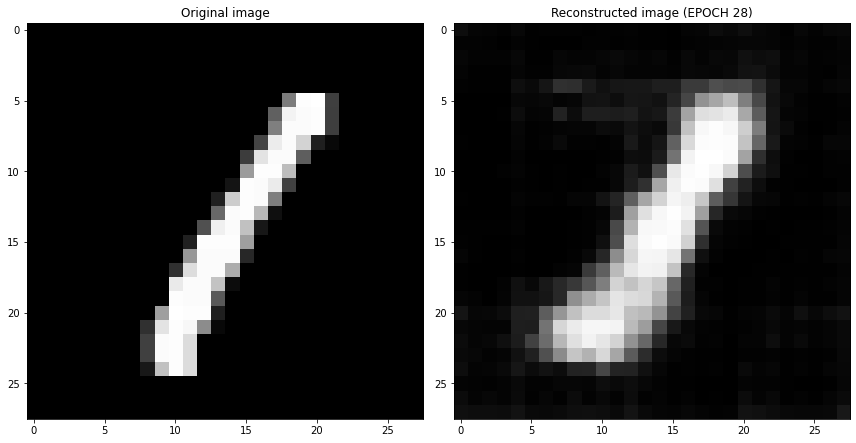

In [ ]:
# Grid Search

param_grid, n_iter = set_hyperparameters()

gs_train_loss = []
gs_val_loss = []

num_epochs = 500
early_stop_threshold = 10

for i,parameters in enumerate(param_grid):

  batch_size = parameters[0]

  encoder, decoder, loss_fun, optimizer = initialize_net(parameters)

  ### Cross Validation
  cv_train_loss = []
  cv_val_loss = []
  
  n_fold = 4       
  kfold = KFold(n_fold, True)  # Create kfolds to iterate the training

  for (fold, indexes) in (enumerate(kfold.split(train_dataset))):          # for each kfold used as validation
    print('Training on hyperparameter set {} out of {}'.format(i+1, n_iter))
    print('Training on fold: {}'.format(fold))

    train_index = indexes[0]
    val_index = indexes[1]

    # Create the training and validation sets
    train_dataset_kfold = Subset(train_dataset, train_index)
    val_dataset_kfold = Subset(train_dataset, val_index)


    cv_train_dataloader = DataLoader(train_dataset_kfold, batch_size=batch_size, shuffle=False)
    cv_val_dataloader = DataLoader(val_dataset_kfold, batch_size=len(val_dataset_kfold), shuffle=False)

    # real training
    val_loss_log = []
    train_loss_log = []

    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))

        train_loss = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=cv_train_dataloader, 
            loss_fun=loss_fun, 
            optimizer=optimizer)
        
        train_loss_log.append(train_loss)

        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=cv_val_dataloader, 
            loss_fun=loss_fun)
        
        val_loss_log.append(val_loss)
        
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
        
        # show image for the last epoch
        # Early stopping if the average loss over the last 2 epochs is grater than the average loss over the previous 3
        if num_epochs > early_stop_threshold and np.mean(val_loss_log[-2:]) > np.mean(val_loss_log[-early_stop_threshold:-2]):
          print('EARLY STOPPING')
          
          img = val_dataset_kfold[0][0].unsqueeze(0).to(device)

          encoder.eval()
          decoder.eval()
          
          with torch.no_grad():
              rec_img  = decoder(encoder(img))
          
          # reshape the images to use the imshow function - from 1x3x32x32 to 32x32x3
          img = img.squeeze() 
          rec_img = rec_img.squeeze() 
          
          # Plot the reconstructed image
          fig, axs = plt.subplots(1, 2, figsize=(12,6))
          axs[0].imshow(img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')
          axs[0].set_title('Original image')
          axs[1].imshow(rec_img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')
          axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
          
          param_str = str(parameters[0])+'_'+str(parameters[1])+'_'+str(parameters[2])#+'_'+str(parameters[3])+'_'+str(parameters[4])
          plt.savefig(fname = 'Reconstructed_image' + param_str + '_fold_' + str(fold))
          
          plt.tight_layout()
          plt.pause(0.1)
          break # early stopping


    # Save Loss for each Kfold
    cv_train_loss.append(train_loss_log)
    cv_val_loss.append(val_loss_log)

    encoder.apply(weight_reset)
    decoder.apply(weight_reset)

  # Save Grid Search Performance
  gs_train_loss.append(cv_train_loss)
  gs_val_loss.append(cv_val_loss)

In [ ]:
# define a function to deal with the different length of loss records due to the early stopping, i.e. computes the mean only where possible

def tolerant_mean(arrays):
    lens = [len(i) for i in arrays]
    array = np.ma.empty((np.max(lens),len(arrays)))
    array.mask = True
    
    for idx, l in enumerate(arrays):
      array[:len(l),idx] = l
    return array.mean(axis = -1), array.std(axis=-1)

In [ ]:
hset_loss = []
h_set_mean_train_loss = []
h_set_mean_val_loss = []

for hset in gs_val_loss:  # for each hyperparameter set
  final_loss = [np.mean(cv[-5:]) for cv in hset]
  hset_loss.append(np.mean(final_loss))
  h_set_mean_val_loss.append(tolerant_mean([cv for cv in hset]))   # mean over the k fold loss of that particular hyperparameter set
  
for hset in gs_train_loss:
  h_set_mean_train_loss.append(tolerant_mean([cv for cv in hset]))
  
param_grid, n_iter = set_hyperparameters()

param_grid = [i for i in param_grid]
best_hyper = param_grid[np.argmin(hset_loss)]
print('Validation loss over all the hyperparameters sets: {}'.format((hset_loss)))
print('Best validation loss: {}'.format(min(hset_loss)))
print('Best set of hyperparameters: {}'.format(best_hyper))

Validation loss over all the hyperparameters sets: [0.077803165, 0.074066706, 0.0804916, 0.0768863, 0.07793958, 0.07760071, 0.07609938, 0.07674144, 0.07599577, 0.07505381, 0.07245809, 0.07187757, 0.07477533, 0.059773155, 0.07538025, 0.07238678, 0.0486435, 0.04807057]
Best validation loss: 0.04807056859135628
Best set of hyperparameters: (256, 16, 'elu', 0.003, 1e-06)


In [ ]:
# explore the best performing hyperparameter sets
hset_loss_ind = np.array(hset_loss).argsort()

max_indexes = hset_loss_ind[:10]   # select the n best results
for i in max_indexes:
  print('Hyperparameter set {}: {}'.format(param_grid[i], hset_loss[i]))

Hyperparameter set (256, 16, 'elu', 0.003, 1e-06): 0.04807056859135628
Hyperparameter set (256, 16, 'elu', 0.003, 1e-05): 0.04864349961280823
Hyperparameter set (256, 16, 'leaky', 0.003, 1e-06): 0.05977315455675125
Hyperparameter set (256, 4, 'elu', 0.003, 1e-06): 0.07187756896018982
Hyperparameter set (256, 16, 'relu', 0.003, 1e-06): 0.07238677889108658
Hyperparameter set (256, 4, 'elu', 0.003, 1e-05): 0.07245808839797974
Hyperparameter set (256, 2, 'leaky', 0.003, 1e-06): 0.07406670600175858
Hyperparameter set (256, 16, 'leaky', 0.003, 1e-05): 0.074775330722332
Hyperparameter set (256, 4, 'relu', 0.003, 1e-06): 0.07505381107330322
Hyperparameter set (256, 16, 'relu', 0.003, 1e-05): 0.07538025081157684


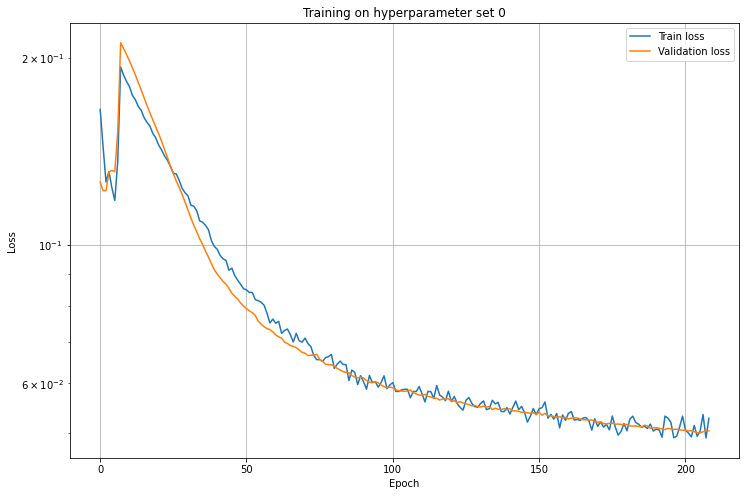

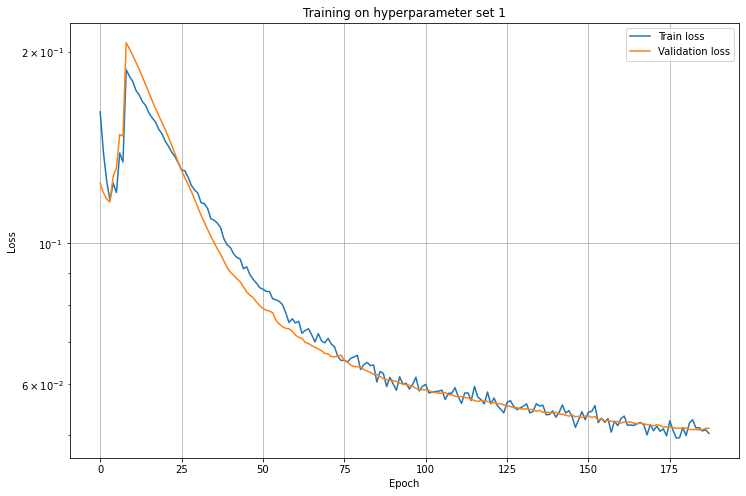

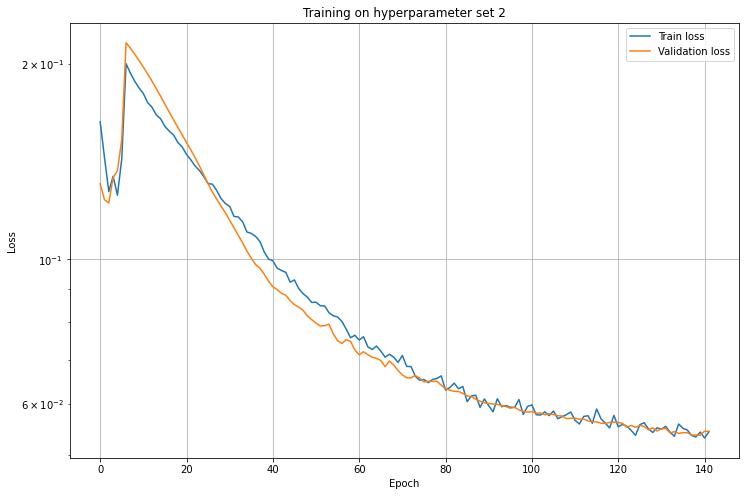

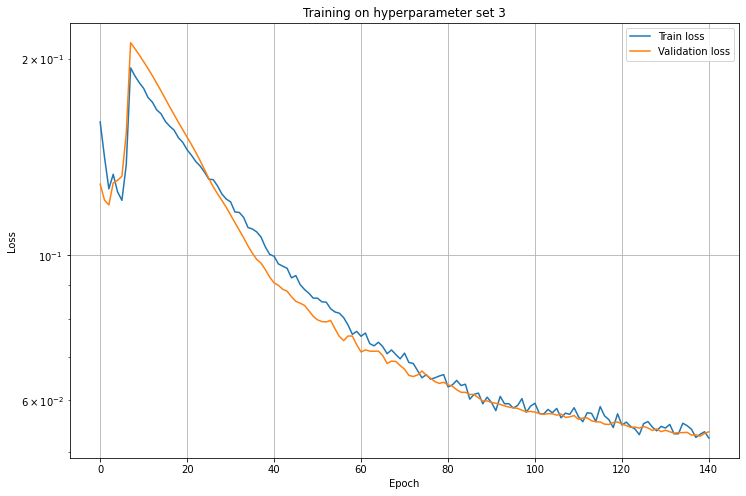

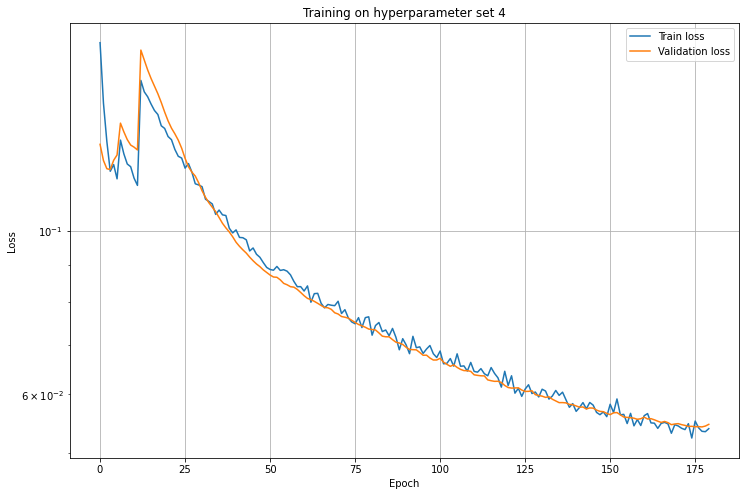

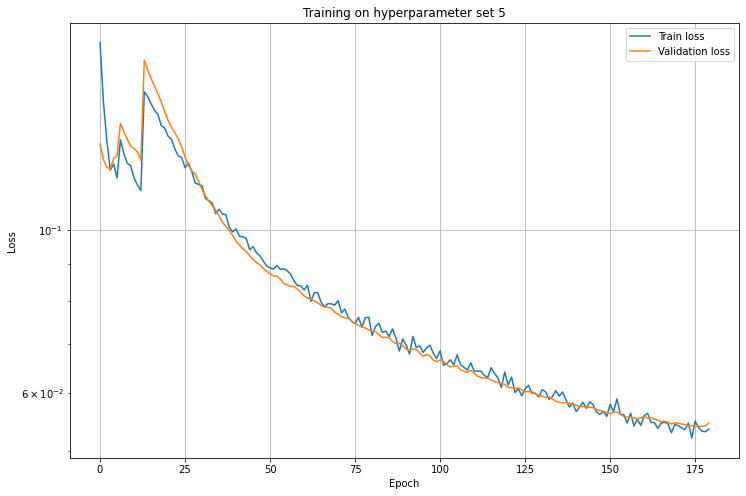

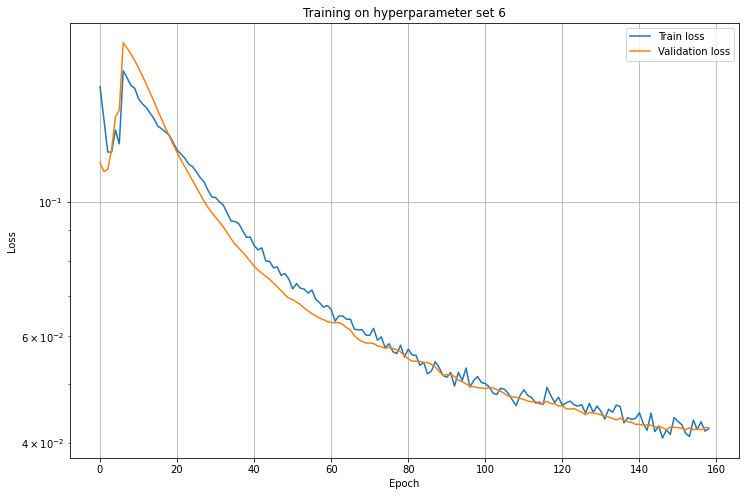

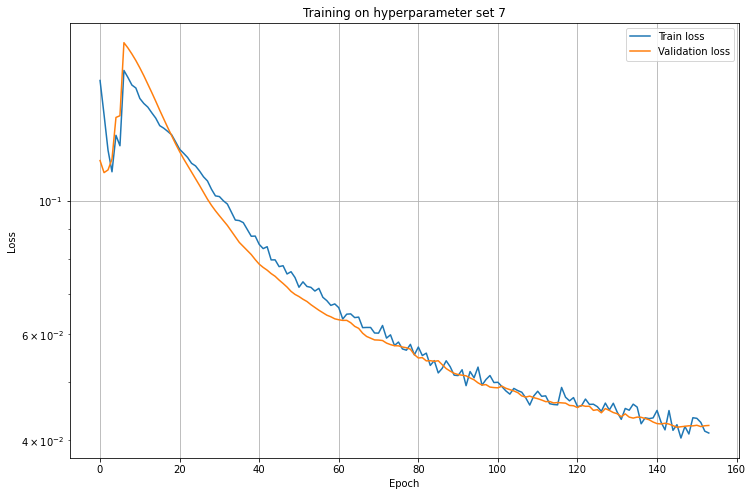

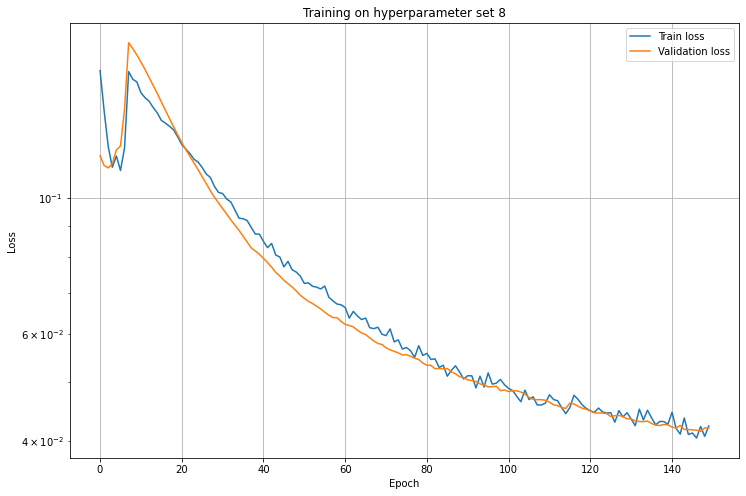

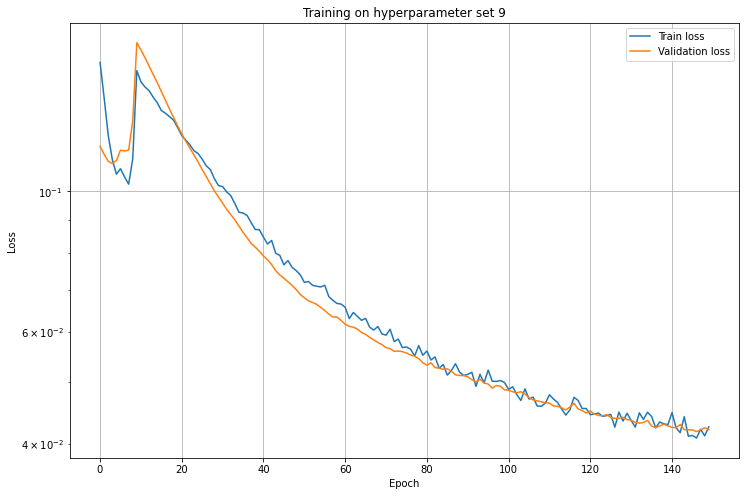

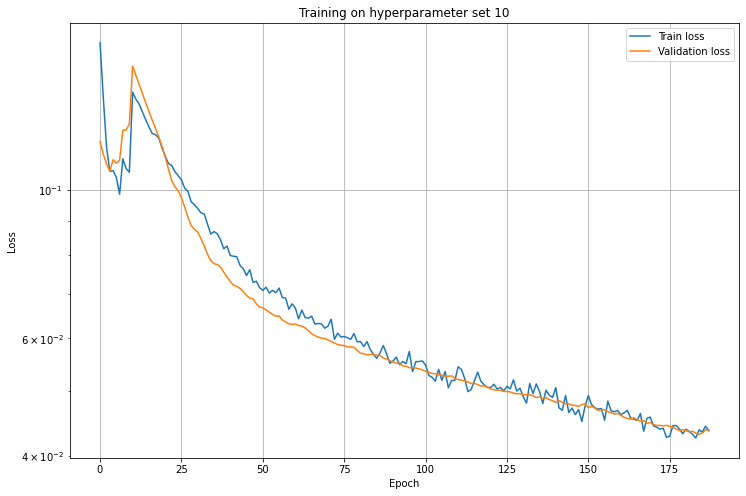

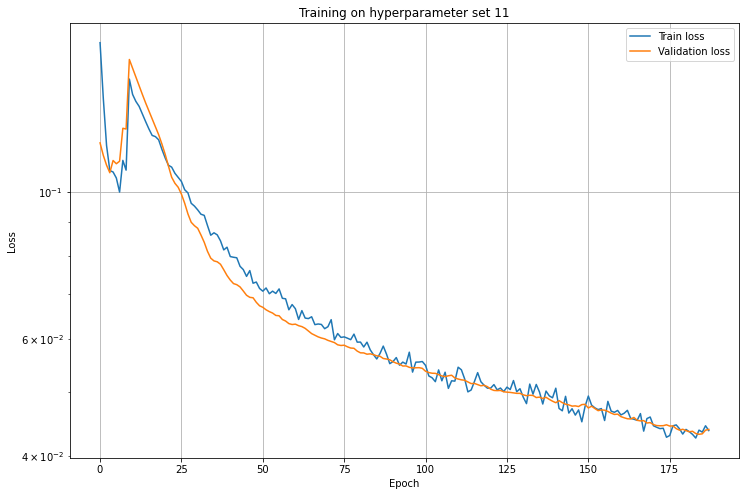

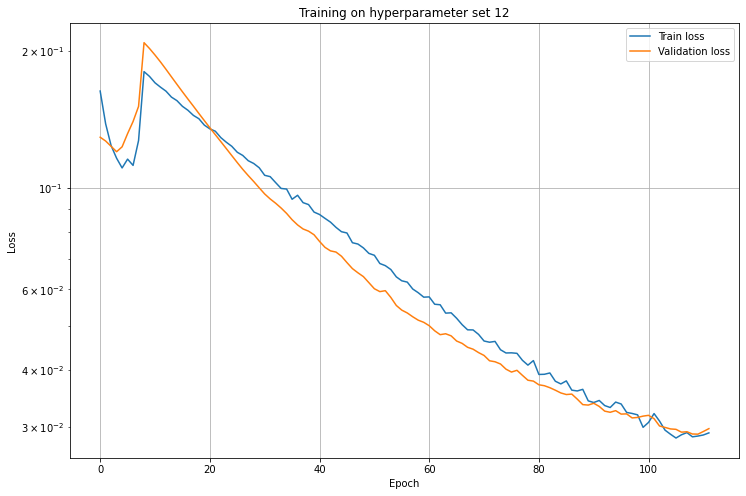

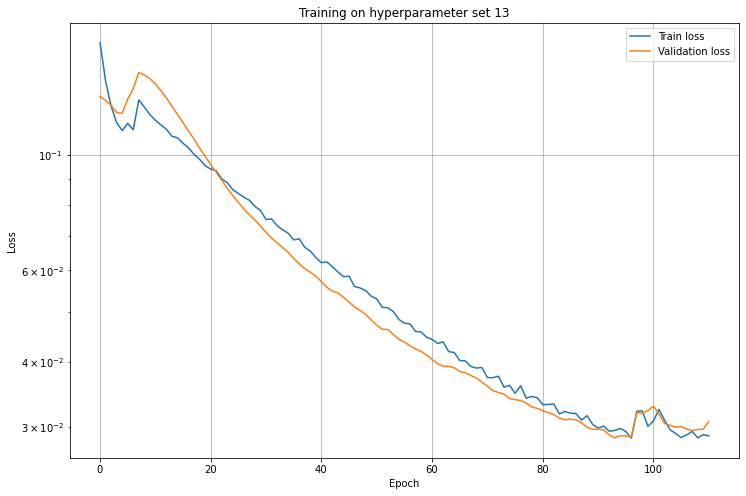

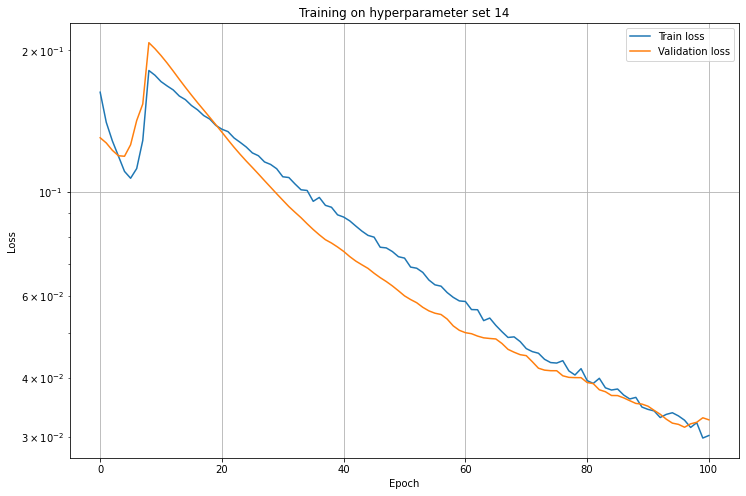

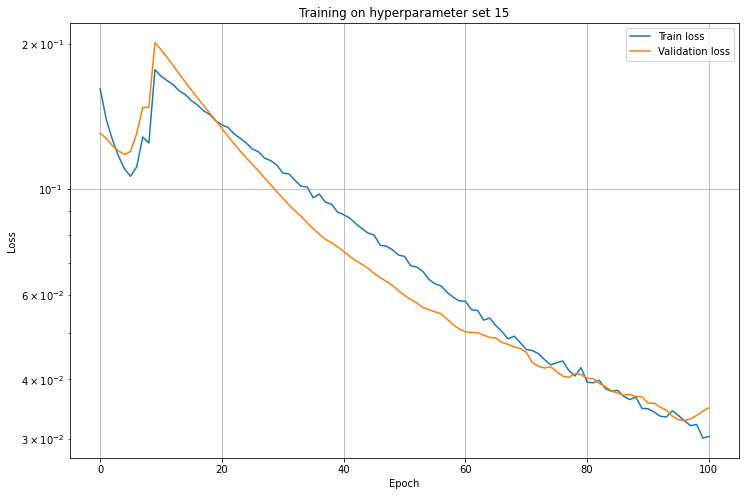

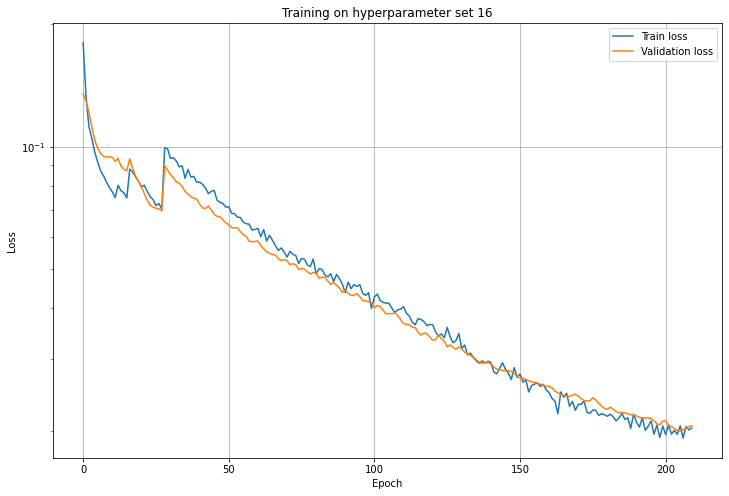

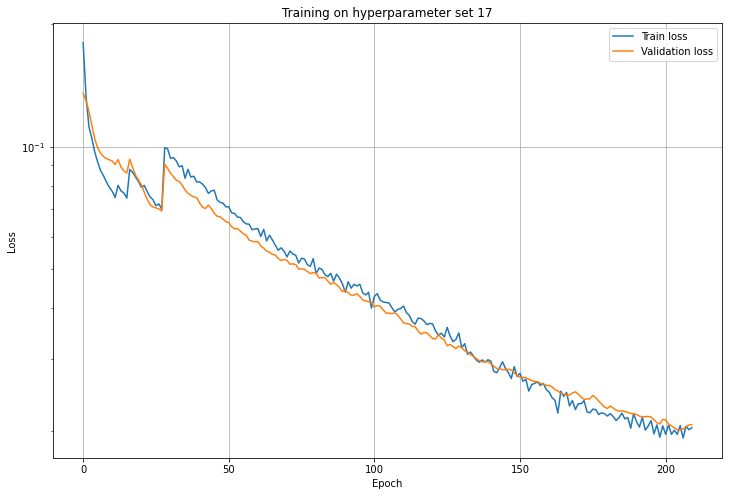

In [ ]:
# show training plots
for i in range(n_iter):
  plt.figure(figsize=(12,8))
  plt.semilogy(h_set_mean_train_loss[i][0], label='Train loss')
  plt.semilogy(h_set_mean_val_loss[i][0], label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training on hyperparameter set {}'.format(i))
  plt.grid()
  plt.legend()
  plt.show()

In [ ]:
best_hyperparams = [256, 16, 'elu', 3e-3, 1e-6]

# Encoded space dimension analysis

In [ ]:
# final training, hyperparameters set, change only encoded space dimension
def set_hyperparameters():

  batch_size_set = [256]                
  enc_dim_set = [i for i in range(2, 41, 2)]   #this is the only hyperparameter studied here
  activation_set = ['elu']
  lr_set = [5e-3] 
  weight_decay = [1e-6]

  param_grid = itertools.product(batch_size_set, enc_dim_set, activation_set, lr_set, weight_decay)

  n_iter = len(batch_size_set)*len(enc_dim_set)*len(activation_set)*len(lr_set)*len(weight_decay)

  return param_grid, n_iter

Training on hyperparameter set 1 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.228046


EPOCH 2/500


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




	 VALIDATION - EPOCH 2/500 - loss: 0.223501


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.217701


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.211340


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.204923


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.198293


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.191381


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.184261


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.177004


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.169549


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.162094


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.154956


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.148394


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.142614


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.137692


EPOCH 16/500


	 VALIDATION - EPOCH 16/500 - loss: 0.133330


EPOCH 17/500


	 VALIDATION - EPOCH 17/500 - loss: 0.128779


EPOCH 18/500


	 VALIDATION - EPOCH 

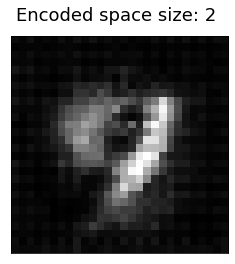

Training on hyperparameter set 2 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.192901


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.187363


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.181612


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.175301


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.168971


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.162827


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.156570


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.149904


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.142988


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.136415


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.130730


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.125776


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.120788


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.115459


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.110265


EPOCH 16/5

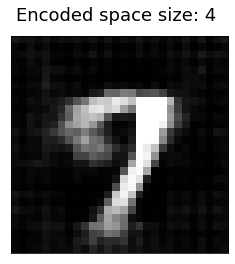

Training on hyperparameter set 3 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.245473


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.240733


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.235915


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.229579


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.222136


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.213788


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.204875


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.195549


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.185731


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.175493


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.165327


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.155584


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.145812


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.135912


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.126313


EPOCH 16/5

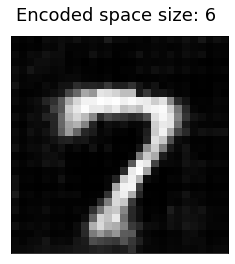

Training on hyperparameter set 4 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.197811


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.192671


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.186368


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.178674


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.170893


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.164225


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.157907


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.150395


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.144233


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.135870


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.126011


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.120819


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.114563


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.105796


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.100131


EPOCH 16/5

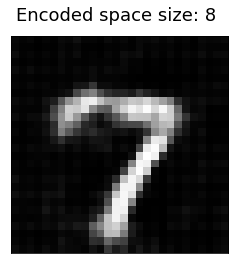

Training on hyperparameter set 5 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.201992


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.196786


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.191099


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.184585


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.177708


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.171491


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.166498


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.161314


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.154234


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.145325


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.137819


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.130014


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.121149


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.113041


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.106707


EPOCH 16/5

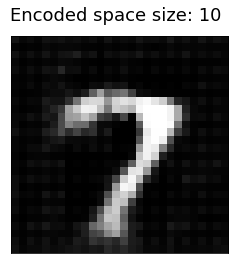

Training on hyperparameter set 6 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.211060


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.206997


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.201967


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.195745


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.188727


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.181154


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.173021


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.164244


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.154808


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.144935


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.135283


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.126471


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.118316


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.110394


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.102978


EPOCH 16/5

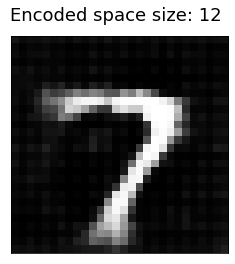

Training on hyperparameter set 7 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.212729


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.207482


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.201478


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.194548


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.186930


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.178945


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.170668


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.162425


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.154622


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.146527


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.137820


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.129780


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.123310


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.116599


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.108866


EPOCH 16/5

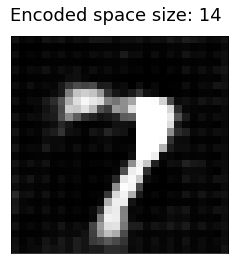

Training on hyperparameter set 8 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.230956


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.224129


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.216717


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.208626


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.199374


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.190337


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.181999


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.171572


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.160059


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.152138


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.142207


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.135471


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.128202


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.118171


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.109663


EPOCH 16/5

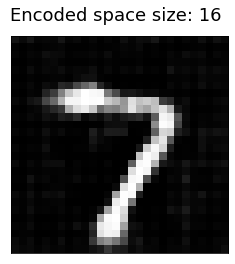

Training on hyperparameter set 9 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.187060


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.182229


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.176310


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.169533


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.162428


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.155296


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.147970


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.140100


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.132353


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.124249


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.116304


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.109697


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.103526


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.096555


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.089351


EPOCH 16/5

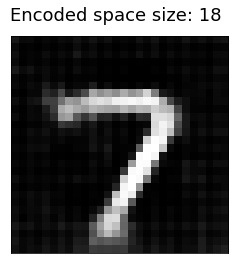

Training on hyperparameter set 10 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.222308


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.216618


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.210268


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.203236


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.195460


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.187080


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.178066


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.167988


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.156638


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.146971


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.137362


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.129948


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.116702


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.114090


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.103483


EPOCH 16/

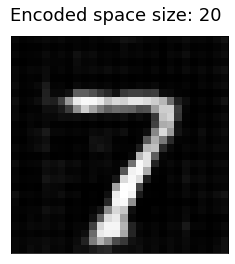

Training on hyperparameter set 11 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.243735


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.236941


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.228236


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.218136


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.206911


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.194876


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.184108


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.172192


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.159795


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.151818


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.137418


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.129114


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.118723


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.109778


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.104171


EPOCH 16/

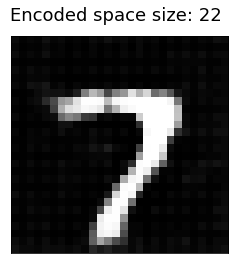

Training on hyperparameter set 12 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.186766


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.182415


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.177458


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.172038


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.166269


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.159611


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.151806


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.143159


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.134558


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.128157


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.119500


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.108874


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.103428


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.095383


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.085322


EPOCH 16/

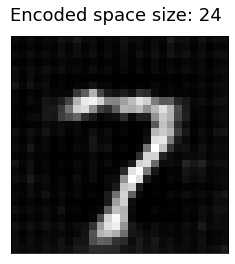

Training on hyperparameter set 13 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.231116


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.226425


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.220917


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.214391


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.206985


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.198657


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.189126


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.178162


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.166926


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.156363


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.146329


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.136325


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.126620


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.115366


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.105905


EPOCH 16/

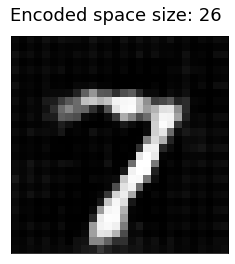

Training on hyperparameter set 14 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.182315


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.177061


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.171118


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.164127


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.156206


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.147695


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.138925


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.129499


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.119646


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.109779


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.102357


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.094938


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.087430


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.081366


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.074167


EPOCH 16/

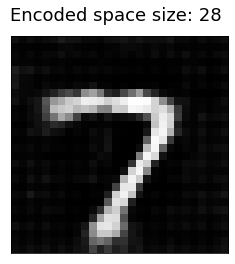

Training on hyperparameter set 15 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.192555


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.187565


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.182103


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.175951


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.169004


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.161452


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.153093


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.145094


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.138231


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.131321


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.124807


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.116847


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.108882


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.103996


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.098622


EPOCH 16/

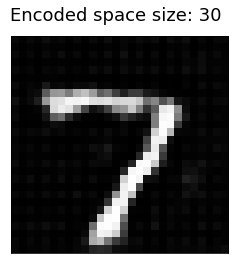

Training on hyperparameter set 16 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.224630


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.220720


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.215610


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.209088


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.201475


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.192935


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.183359


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.172927


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.161653


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.148905


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.136906


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.128448


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.119337


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.108149


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.098873


EPOCH 16/

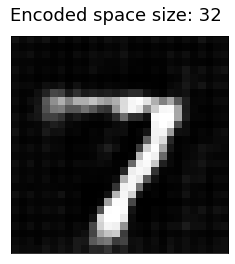

Training on hyperparameter set 17 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.183081


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.179567


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.175498


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.170910


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.165802


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.160158


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.153462


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.145394


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.136872


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.128359


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.119786


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.111676


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.103538


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.096017


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.089076


EPOCH 16/

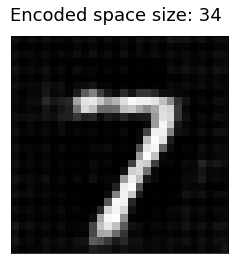

Training on hyperparameter set 18 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.249353


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.240832


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.230563


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.219667


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.210099


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.200791


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.186853


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.173097


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.162772


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.151890


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.139455


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.127668


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.118114


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.109449


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.100037


EPOCH 16/

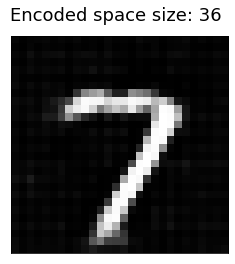

Training on hyperparameter set 19 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.278959


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.273305


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.265878


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.256616


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.246407


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.235507


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.225088


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.211142


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.193396


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.179608


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.169010


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.154879


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.144158


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.131107


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.119359


EPOCH 16/

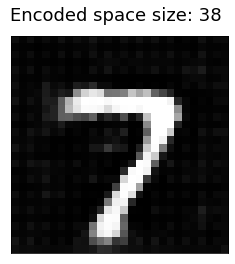

Training on hyperparameter set 20 out of 20
Network and parameters initialized
EPOCH 1/500


	 VALIDATION - EPOCH 1/500 - loss: 0.184496


EPOCH 2/500


	 VALIDATION - EPOCH 2/500 - loss: 0.181159


EPOCH 3/500


	 VALIDATION - EPOCH 3/500 - loss: 0.176961


EPOCH 4/500


	 VALIDATION - EPOCH 4/500 - loss: 0.171900


EPOCH 5/500


	 VALIDATION - EPOCH 5/500 - loss: 0.166300


EPOCH 6/500


	 VALIDATION - EPOCH 6/500 - loss: 0.160499


EPOCH 7/500


	 VALIDATION - EPOCH 7/500 - loss: 0.154155


EPOCH 8/500


	 VALIDATION - EPOCH 8/500 - loss: 0.146444


EPOCH 9/500


	 VALIDATION - EPOCH 9/500 - loss: 0.137760


EPOCH 10/500


	 VALIDATION - EPOCH 10/500 - loss: 0.128226


EPOCH 11/500


	 VALIDATION - EPOCH 11/500 - loss: 0.118539


EPOCH 12/500


	 VALIDATION - EPOCH 12/500 - loss: 0.108742


EPOCH 13/500


	 VALIDATION - EPOCH 13/500 - loss: 0.099736


EPOCH 14/500


	 VALIDATION - EPOCH 14/500 - loss: 0.091344


EPOCH 15/500


	 VALIDATION - EPOCH 15/500 - loss: 0.083872


EPOCH 16/

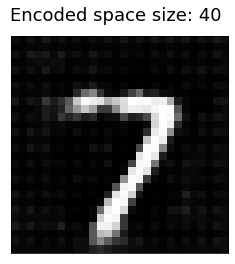

In [ ]:
# train for different encoded space dimensions and then plot them with their reconstructions
param_grid, n_iter = set_hyperparameters()

gs_train_loss = []
gs_val_loss = []

num_epochs = 500
early_stop_threshold = 10

for i,parameters in enumerate(param_grid):
  print('Training on hyperparameter set {} out of {}'.format(i+1, n_iter))

  batch_size = parameters[0]

  encoder, decoder, loss_fun, optimizer = initialize_net(parameters)
  encoded_space_dim = parameters[1]

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  val_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

  # real training
  val_loss_log = []
  train_loss_log = []

  for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))

    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fun=loss_fun, 
        optimizer=optimizer)
    
    train_loss_log.append(train_loss)

    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fun=loss_fun)
    
    val_loss_log.append(val_loss)
    
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
    
    # show image for the last epoch
    # Early stopping if the average loss over the last 2 epochs is grater than the average loss over the previous 3
    if num_epochs > early_stop_threshold and np.mean(val_loss_log[-2:]) > np.mean(val_loss_log[-early_stop_threshold:-2]):
      print('EARLY STOPPING')
      
      img = test_dataset[0][0].unsqueeze(0).to(device)

      encoder.eval()
      decoder.eval()
      
      with torch.no_grad():
          rec_img  = decoder(encoder(img))
      
      # reshape the images to use the imshow function - from 1x3x32x32 to 32x32x3
      img = img.squeeze() 
      rec_img = rec_img.squeeze() 

      plt.figure(figsize=(4,4))
      plt.suptitle('Encoded space size: {}'.format(encoded_space_dim), fontsize=18)

      plt.imshow(rec_img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')
      plt.xticks([])
      plt.yticks([])
      plt.savefig(fname = 'Reconstructed_image_encsize_' + str(i+1))
      plt.show()

      break # early stopping

      plt.figure(figsize=(4,4))
      plt.imshow(rec_img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')

  if i!=n_iter-1: # don't reset weights in the last training
    encoder.apply(weight_reset)
    decoder.apply(weight_reset)

  # Save Grid Search Performance
  gs_train_loss.append(train_loss_log)
  gs_val_loss.append(val_loss_log)

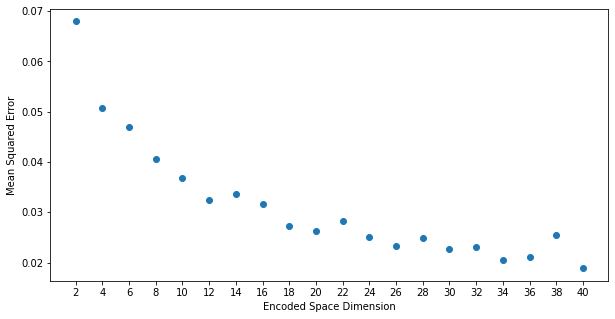

In [ ]:
# plot reconstruction error against encoded space dimension

avg_loss = [np.mean(i[-5:]) for i in gs_val_loss]

enc_dim_set = [i for i in range(2, 41, 2)] 

plt.figure(figsize=(10,5))
plt.scatter(enc_dim_set, avg_loss)
plt.xlabel('Encoded Space Dimension')
plt.ylabel('Mean Squared Error')
plt.xticks(enc_dim_set)

plt.savefig('enc_space_analysis')
plt.show()

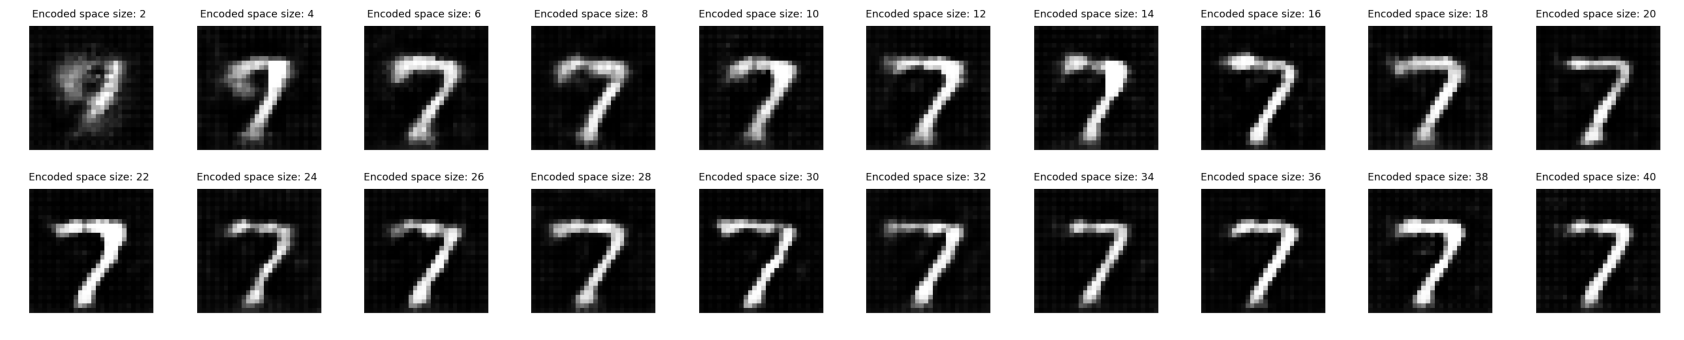

In [ ]:
# load images to show, saved in the training loop
param_grid, n_iter = set_hyperparameters()
reconstructed_images = []
param_str = str(parameters[0])+'_'+str(parameters[1])+'_'+str(parameters[2])
for i,param in enumerate(param_grid):
  param_str = 'Reconstructed_image_encsize_' + str(i+1)
  reconstructed_images.append(plt.imread(param_str + '.png'))

fig = plt.figure(figsize=(30,6))
gs1 = gridspec.GridSpec(2, 10)
gs1.update(wspace=0.00001, hspace=0.00001)

for i in range(2 * 10):
    plt.subplot(gs1[i])
    plt.axis('off')
    plt.imshow(reconstructed_images[i], cmap='gist_gray')

plt.savefig('enc_space_analysis_images')

# Final Training

In [ ]:
# initialize the network

# parameters: batch_size, encoded_space_dim, activation, lr, weight_decay
parameters = [256, 20, 'elu', 5e-3, 1e-6]
encoder, decoder, loss_fun, optimizer = initialize_net(parameters)

Network and parameters initialized


In [ ]:
### final training
num_epochs = 500
early_stop_threshold = 20

val_loss_log = []
train_loss_log = []

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))

    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fun=loss_fun, 
        optimizer=optimizer)
    
    train_loss_log.append(train_loss)

    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fun=loss_fun)
    
    val_loss_log.append(val_loss)
    
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    img = test_dataset[0][0].unsqueeze(0).to(device)

    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    
    img = img.squeeze() 
    rec_img = rec_img.squeeze() 
    
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    
    # Early stopping if the average loss over the last 2 epochs is grater than the average loss over the previous 3
    if epoch > early_stop_threshold and np.mean(val_loss_log[-5:]) > np.mean(val_loss_log[-early_stop_threshold:-2]):
      print('EARLY STOPPING')
      break

Output hidden; open in https://colab.research.google.com to view.

Reconstruction loss: 0.0110155725851655


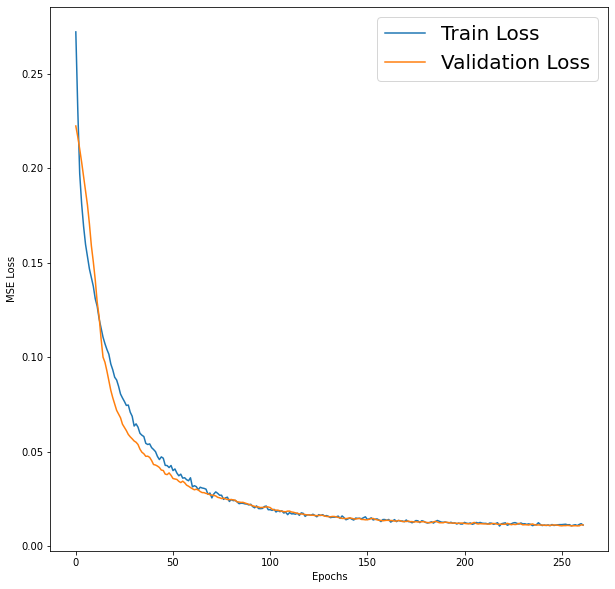

In [ ]:
# plot the learning curves

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(range(epoch+1), train_loss_log, label='Train Loss')
ax.plot(range(epoch+1), val_loss_log, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE Loss')
ax.legend( prop={'size': 20})

plt.savefig('learning_plot_autoencoder')

print('Reconstruction loss: {}'.format(np.mean(val_loss_log[-5:])))

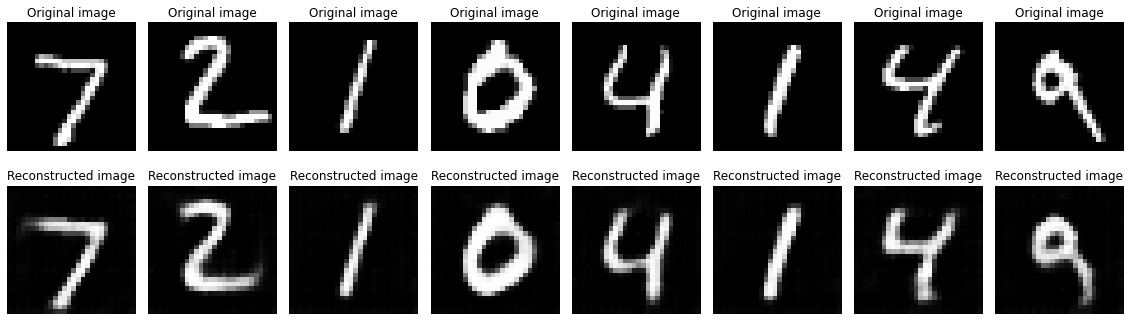

In [ ]:
# plot
fig = plt.figure(figsize=(20,6))
gs1 = matplotlib.gridspec.GridSpec(2, 8)
gs1.update(wspace=0.1, hspace=0.00001)

for i in range(8):
  img = test_dataset[i][0].unsqueeze(0).to(device)

  encoder.eval()
  decoder.eval()

  with torch.no_grad():
      rec_img  = decoder(encoder(img))

  img = img.squeeze()

  ax = plt.subplot(gs1[i+8])
  ax.set_title('Reconstructed image')
  ax.axis('off')
  ax.imshow(rec_img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')
  
  ax2 = plt.subplot(gs1[i])
  ax2.set_title('Original image')
  ax2.axis('off')
  ax2.imshow(img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')


plt.savefig('reconstructed_images_autoencoder20')

plt.show()

# Latent space analysis

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:07<00:00, 1264.08it/s]


In [ ]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(encoded_samples)
principalDf = pd.DataFrame(data = principal_components
             , columns = ['Enc. Variable 0', 'Enc. Variable 1'])

In [ ]:
pca_samples = pd.concat([principalDf, encoded_samples.label], axis = 1, join='inner')
pca_samples.head()

,Enc. Variable 0,Enc. Variable 1,label
0,-7.905913,6.018548,7
1,5.485856,-12.899941,2
2,-6.120136,-9.473472,1
3,11.250884,3.791936,0
4,-1.045038,10.422320,4


In [ ]:
# show latent space compressed
px.scatter(pca_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

torch.Size([1, 2])


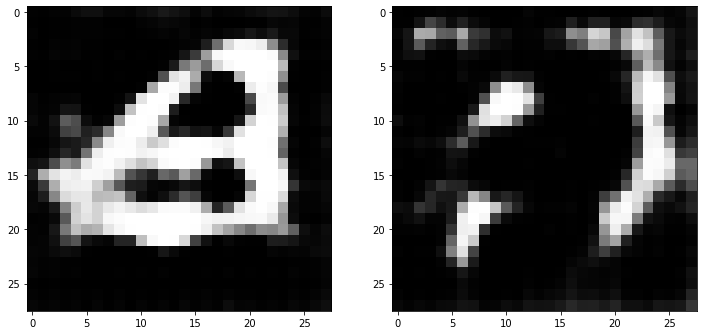

In [ ]:
# sample from encoded space
encoded_sample1 = torch.empty((1, 20)).uniform_(-15, 15).to(device)   # uniform sampling
encoded_sample2 = torch.empty((1, 20)).normal_(mean=0, std=10).to(device)   # normal sampling

decoder.eval()
with torch.no_grad():
    generated_img1  = decoder(encoded_sample1)
    generated_img2  = decoder(encoded_sample2)

plt.figure(figsize=(12,10))
ax = plt.subplot(1,2,1)
ax.imshow(generated_img1.squeeze().cpu().numpy(), cmap='gist_gray')
ax1 = plt.subplot(1,2,2)
ax1.imshow(generated_img2.squeeze().cpu().numpy(), cmap='gist_gray')

plt.savefig('samples_images')
plt.show()

# Classification With Encoder

### Creating Classifier Network

In [ ]:
### use the encoder to extract features and then pass those feature to a simple fc classification network

class Classifier(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(encoded_space_dim, 250)
        self.act = nn.ReLU()
        self.batch1 = nn.BatchNorm1d(250)
        self.fc2 = nn.Linear(250, 100)
        self.batch2 = nn.BatchNorm1d(100)
        self.out = nn.Linear(100, 10)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.batch2(x)
        x = self.act(x)
        x = self.out(x)                
        return x

In [ ]:
# define loss function and parameters to optimize
def initialize_net_class(parameters):

  # parameters:  encoded_space_dim, lr, weight_decay
  lr = parameters[1]
  weight_decay = parameters[2]

  # set the seed
  torch.manual_seed(0)

  # create encoder and decoder
  encoded_space_dim = parameters[0]
  classifier = Classifier(encoded_space_dim)
  classifier.to(device)
  loss_fun = nn.CrossEntropyLoss()

  optimizer = optim.Adam(classifier.parameters(), lr=lr, weight_decay=weight_decay) 

  print('Network and parameters initialized')

  return classifier, loss_fun, optimizer

In [ ]:
## define the training function for classifier
def train_epoch_class(encoder, classifier, optimizer, device, dataloader, loss_fun):

  encoder.eval()
  classifier.train()

  for image, label in train_dataloader:

    image = image.to(device)
    
    label = label.to(device)
    
    encoded_input = encoder(image)

    classification_output = classifier(encoded_input)

    loss = loss_fun(classification_output, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print('\t Partial loss on the batch: {}'.format(loss.data))
    return loss.data

In [ ]:
## define the test function
def test_epoch_class(encoder, classifier, device, dataloader, loss_fun):

    encoder.eval()
    classifier.eval()
    
    with torch.no_grad():
        
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        
        for image, label in dataloader:

            image = image.to(device)
            
            label = label.to(device)

            encoded_input = encoder(image)
            
            classification_output = classifier(encoded_input)

            val_loss = loss_fun(classification_output, label)
    
    return val_loss.data, classification_output

In [ ]:
parameters = [20, 5e-4, 1e-5]
classifier, loss_fun_class, optimizer_class = initialize_net_class(parameters)

Network and parameters initialized


In [ ]:
# training loop

num_epochs = 1000
early_stop_threshold = 20

val_loss_log = []
train_loss_log = []

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))

    train_loss = train_epoch_class(
        encoder=encoder, 
        classifier=classifier,
        device=device, 
        dataloader=train_dataloader, 
        loss_fun=loss_fun_class, 
        optimizer=optimizer_class)
    
    train_loss_log.append(train_loss.cpu())

    val_loss, classification_output = test_epoch_class(
        encoder=encoder, 
        classifier=classifier,
        device=device, 
        dataloader=test_dataloader, 
        loss_fun=loss_fun_class)
    
    val_loss_log.append(val_loss.cpu())
    
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    img = test_dataset[0][0].unsqueeze(0).to(device)
    label = test_dataset[0][1]

    encoder.eval()
    classifier.eval()
    
    with torch.no_grad():
        output_label  = classifier(encoder(img))
    
    pred = output_label.detach().cpu().numpy()
    pred = np.argmax(pred, 1).squeeze()

    # reshape the images to use the imshow function - from 1x3x32x32 to 32x32x3
    img = img.squeeze() 
    
    fig = plt.figure(figsize=(4,4))
    plt.imshow(img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')
    fig.suptitle('Predicted label: {}'.format(pred) + '\n' + 'True label: {}'.format(label), fontdict={'fontsize':50})
    plt.pause(0.1)


    # Early stopping if the average loss over the last 2 epochs is grater than the average loss over the previous 3
    if epoch > early_stop_threshold and np.mean(val_loss_log[-5:]) > np.mean(val_loss_log[-early_stop_threshold:-2]):
      print('EARLY STOPPING')
      break

Output hidden; open in https://colab.research.google.com to view.

Validation error: 0.10546340048313141


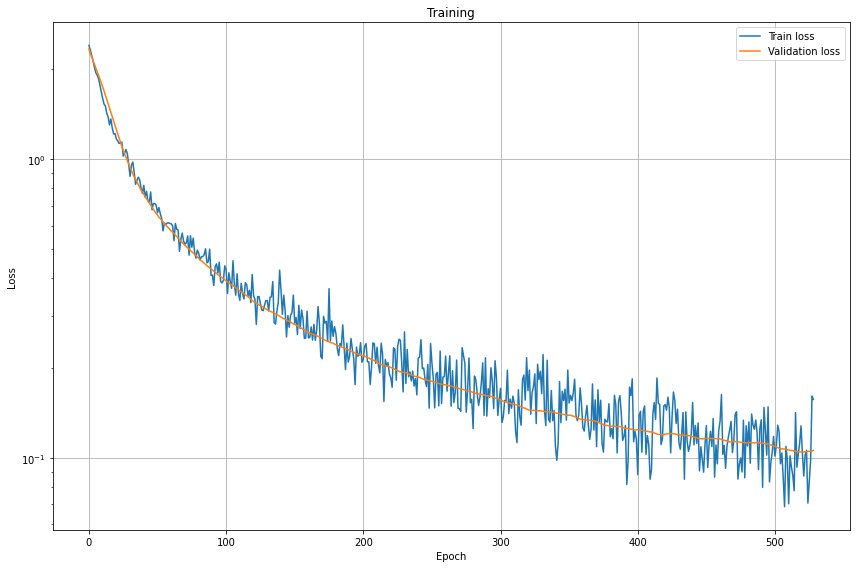

In [ ]:
#Plot
print('Validation error: {}'.format(np.mean(val_loss_log[-5:])))

plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training')
plt.grid()
plt.legend()

plt.tight_layout()

plt.savefig('training_plot')

plt.show()

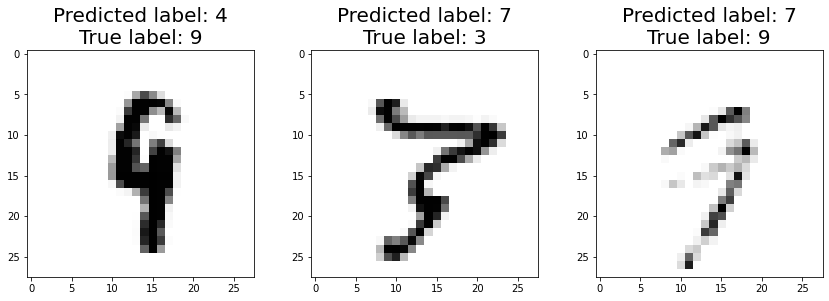

In [ ]:
# use the last predictions made in the test set
for test_images, test_label in test_dataloader:
    break

pred = classification_output.detach().cpu().numpy()
pred = np.argmax(pred, 1).squeeze()
pred = [int(a) for a in pred]
labels = [int(a) for a in test_label.detach().cpu().numpy()]
samples = test_images.squeeze().detach().cpu().numpy()

#index of misclassified samples
misclass_indexes = [i for i in range(len(pred)) if pred[i]!=labels[i]]

rand_indexes = np.random.choice(misclass_indexes, 3)

#plot 3 misclassified images
fig, axs = plt.subplots(1,3,figsize = (12,4))

for i, index in enumerate(rand_indexes):
  axs[i].imshow(samples[index], cmap = 'Greys')
  axs[i].set_title('Predicted label: {}'.format(pred[index]) + '\n' + 'True label: {}'.format(labels[index]), fontdict={'fontsize':20})

plt.tight_layout()

plt.savefig('misclassified_images')

plt.show()

In [ ]:
# analyse the final accuracy and the number of misclassified samples
print('Number of misclassified samples: {} out of {}'.format(len(misclass_indexes), len(test_dataset))) 
print('Accuracy: {}'.format((len(test_dataset) - len(misclass_indexes))/len(test_dataset)))   

Number of misclassified samples: 306 out of 10000
Accuracy: 0.9694


# Denoising Autoencoder

In [ ]:
# add noise transform
class GaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor): 
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
# add noise to the training and test set transform
transform_noise = transforms.Compose([
    transforms.ToTensor(),
    GaussianNoise(std=0.5)  # change the intensity of the noise through the std param
])

In [ ]:
train_dataset_noise = train_dataset
test_dataset_noise = test_dataset
train_dataset_noise.transform = transform_noise
test_dataset_noise.transform = transform_noise

In [ ]:
train_dataloader_noise = DataLoader(train_dataset_noise, batch_size=256, shuffle=True)
test_dataloader_noise = DataLoader(test_dataset_noise, batch_size=len(test_dataset_noise), shuffle=False)

In [ ]:
# initialize the network

# parameters:  batch_size, encoded_space_dim, activation, lr, weight_decay
parameters = [256, 8, 'elu', 2e-2, 1e-6]
encoder, decoder, loss_fun, optimizer = initialize_net(parameters)

Network and parameters initialized


In [ ]:
# training loop
num_epochs = 500
early_stop_threshold = 20

val_loss_log = []
train_loss_log = []

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))

    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader_noise, 
        loss_fun=loss_fun, 
        optimizer=optimizer)
    
    train_loss_log.append(train_loss)

    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader_noise, 
        loss_fun=loss_fun)
    
    val_loss_log.append(val_loss)
    
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    img = test_dataset_noise[0][0].unsqueeze(0).to(device)

    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    
    # reshape the images to use the imshow function - from 1x3x32x32 to 32x32x3
    img = img.squeeze() 
    rec_img = rec_img.squeeze() 
    
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)

    # Early stopping if the average loss over the last 2 epochs is grater than the average loss over the previous 3
    if epoch > early_stop_threshold and np.mean(val_loss_log[-5:]) > np.mean(val_loss_log[-early_stop_threshold:-2]):
      print('EARLY STOPPING')
      break

Output hidden; open in https://colab.research.google.com to view.

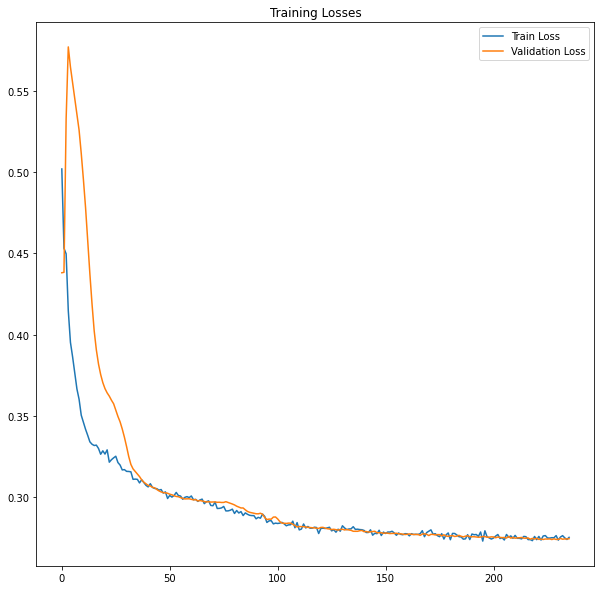

In [ ]:
# plot the learning curves

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(range(epoch+1), train_loss_log, label='Train Loss')
ax.plot(range(epoch+1), val_loss_log, label='Validation Loss')
ax.set_title('Training Losses')
ax.legend()


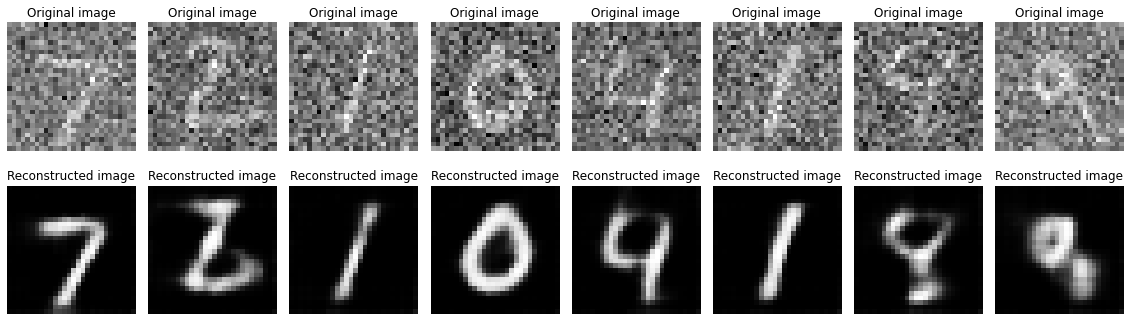

In [ ]:
fig = plt.figure(figsize=(20,6))
gs1 = matplotlib.gridspec.GridSpec(2, 8)
gs1.update(wspace=0.1, hspace=0.00001)

for i in range(8):
  img = test_dataset[i][0].unsqueeze(0).to(device)

  encoder.eval()
  decoder.eval()

  with torch.no_grad():
      rec_img  = decoder(encoder(img))

  img = img.squeeze()
  rec_img = rec_img.squeeze()

  ax = plt.subplot(gs1[i+8])
  ax.set_title('Reconstructed image')
  ax.axis('off')
  ax.imshow(rec_img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')
  
  ax2 = plt.subplot(gs1[i])
  ax2.set_title('Original image')
  ax2.axis('off')
  ax2.imshow(img.cpu().squeeze().numpy().astype(np.float), cmap='gist_gray')

plt.savefig('noisy_reconstruction')